# Setup

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.bayesian_stats as bst
import os
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats
from scipy.stats import t
from scipy.stats import norm

print(f"Running on PyMC v{pm.__version__}")

# Set colors for plotting
rpe_color = '#c51b7d'
te_color = '#276419'
plt.rcParams.update({'font.size': 18})

#Pymc sampling
seed_num = 100
n_samples = 10000

Running on PyMC v4.3.0


## Define Functions

In [2]:
def robust_multiple_linear_regression(X, y, n_draws=1000, rnd_seed=100):
    """Perform a Bayesian multiple linear regression.
    
    Args:
        X (dataframe): Predictor variables are in different columns.
        y (ndarray/Series): The outcome variable.
        
    Returns:
        PyMC Model and InferenceData objects.
    """
    
    # Standardize both predictor and outcome variables.
    if (bst.is_standardized(X)) & (bst.is_standardized(y)):
        pass
    else:
        X, _, _ = bst.standardize(X)
        y, _, _ = bst.standardize(y)
    
    # For explanation of how predictor variables are handled, see:
    # https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    with pm.Model(coords={"predictors": X.columns.values}) as model:
        # Define priors
        zbeta0 = pm.Normal("zbeta0", mu=0, sigma=2)
        zbeta = pm.Normal("zbeta", mu=0, sigma=2, dims="predictors")

        nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
        nu = pm.Exponential("nu", nu_minus_one + 1)
        nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))
        
        mu = zbeta0 + pm.math.dot(X, zbeta)
        zsigma = pm.Uniform("zsigma", 10**-5, 10)
        
        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, lam=1 / zsigma**2, observed=y)
    
        # Sample the posterior
        idata = pm.sample(draws=n_draws, tune=2000, random_seed=rnd_seed)
        
        return model, idata

In [3]:
def BEST(y, group, n_draws=1000, rnd_seed=100):
    """Implementation of John Kruschke's BEST test.
    
    Estimates parameters related to outcomes of two groups. See:
        https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf
        for more details. 
    
    Args:
        y (ndarray/Series): The metric outcome variable.
        group: The grouping variable providing that indexes into y.
        n_draws: Number of random samples to draw from the posterior.
    
    Returns: 
        PyMC Model and InferenceData objects.
    """
    
    # Convert grouping variable to categorical dtype if it is not already
    if pd.api.types.is_categorical_dtype(group):
        pass
    else:
        group = group.astype('category')
    group_idx = group.cat.codes.values
        
    # Extract group levels and make sure there are only two
    level = group.cat.categories
    assert len(level) == 2, f"Expected two groups but got {len(level)}."
    
    # Calculate pooled empirical mean and SD of data to scale hyperparameters
    mu_y = y.mean()
    sigma_y = y.std()
                                                                     
    with pm.Model() as model:
        # Define priors. Arbitrarily set hyperparameters to the pooled 
        # empirical mean of data and twice pooled empirical SD, which 
        # applies very diffuse and unbiased info to these quantities. 
        group_mean = pm.Normal("group_mean", mu=mu_y, sigma=sigma_y * 2, shape=len(level))
        group_std = pm.Uniform("group_std", lower=sigma_y / 10, upper=sigma_y * 10, shape=len(level))
        
        # See Kruschke Ch 16.2.1 for in-depth rationale for prior on nu. The addition of 1 is to shift the
        # distribution so that the range of possible values of nu are 1 to infinity (with mean of 30).
        nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
        nu = pm.Deterministic("nu", nu_minus_one + 1)
        nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))
        
        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=nu, mu=group_mean[group_idx], sigma=group_std[group_idx], observed=y)
        
        # Contrasts of interest
        diff_of_means = pm.Deterministic("difference of means", group_mean[0] - group_mean[1])
        diff_of_stds = pm.Deterministic("difference of stds", group_std[0] - group_std[1])
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((group_std[0]**2 + group_std[1]**2) / 2)
        )
        
        # Sample from posterior
        idata = pm.sample(draws=n_draws, tune=2000, random_seed=rnd_seed)
        
    return model, idata

In [4]:
def robust_bayesian_mixed_model_anova(between_subj_var, within_subj_var, subj_id, y, n_draws=1000, rnd_seed=100):
    """Performs Bayesian analogue of mixed model (split-plot) ANOVA.
    
    Models instance of outcome resulting from both between- and within-subjects
    factors. Outcome is measured several times from each observational unit (i.e.,
    repeated measures). 
    
    Args:
        between_subj_var: The between-subjects variable.
        withing_subj_var: The within-subjects variable.
        subj_id: The subj ID variable. 
        y: The outcome variable. 
    
    Returns: 
        PyMC Model and InferenceData objects. 
    """
    # Statistical model: Split-plot design after Kruschke Ch. 20
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(between_subj_var)
  
    # Within-subjects factor (i.e., target set)
    x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(within_subj_var)

    # Individual subjects
    x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(subj_id)

    # Dependent variable 
    mu_y = y.mean()
    sigma_y = y.std()

    a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)

    with pm.Model(coords={
        "between_subj": levels_x_between, 
        "within_subj": levels_x_within,
        "subj": levels_x_subj}
        ) as model:

        # Baseline value
        a0 = pm.Normal('a0', mu=mu_y, sigma=sigma_y * 5)

        # Deflection from baseline for between subjects factor
        sigma_B = pm.Gamma('sigma_B', a_shape, a_rate)
        aB = pm.Normal('aB', mu=0.0, sigma=sigma_B, dims="between_subj")

        # Deflection from baseline for within subjects factor
        sigma_W = pm.Gamma('sigma_W', a_shape, a_rate)
        aW = pm.Normal('aW', mu=0.0, sigma=sigma_W, dims="within_subj")

        # Deflection from baseline for combination of between and within subjects factors
        sigma_BxW = pm.Gamma('sigma_BxW', a_shape, a_rate)
        aBxW = pm.Normal('aBxW', mu=0.0, sigma=sigma_BxW, dims=("between_subj", "within_subj"))

        # Deflection from baseline for individual subjects
        sigma_S = pm.Gamma('sigma_S', a_shape, a_rate)
        aS = pm.Normal('aS', mu=0.0, sigma=sigma_S, dims="subj")

        mu = a0 + aB[x_between] + aW[x_within] + aBxW[x_between, x_within] + aS[x_subj] 
        
        #Assumes same variance
        # sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10)
        #Assumes different variances 
        sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10, dims=("between_subj", "within_subj"))

        #Prior on nu parameter
        nu_minus1 = pm.Exponential('nu_minus1', 1 / 29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)     
        
        # Define likelihood 
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma[x_between, x_within], observed=y)
        # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma_y, observed=y)
        
        # Sample from the posterior
        idata = pm.sample(draws=n_draws, tune=2000, target_accept=0.95, random_seed=rnd_seed)
    
    return model, idata

In [5]:
def plot_post_predictive_ttest(data, group, post, n_samps=20):
    
    grp_names = np.unique(group)
    var_name = data.name
    # Set colors for plotting

    grp_colors = ['#c51b7d', '#276419']
    
    x = np.linspace(np.min(post.group_mean)-np.max(post.group_std),np.max(post.group_mean)+np.max(post.group_std))
    rand_idx = np.random.choice(len(post.group_mean[0,:]), n_samps)

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].hist(data[group==grp_names[0]], bins=10, density=True, alpha=0.5, color=grp_colors[0])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[0,i], scale=post.group_std[0,i])
        ax[0].plot(x, y, c=grp_colors[0], alpha=0.2)
    ax[0].set(title=grp_names[0]+' group', ylabel='probability', xlabel=var_name)

    ax[1].hist(data[group==grp_names[1]],bins=10, density=True, alpha=0.5, color=grp_colors[1])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[1,i], scale=post.group_std[1,i])
        ax[1].plot(x, y, c=grp_colors[1], alpha=0.2)
    ax[1].set(title=grp_names[1]+' group', xlabel=var_name)
    
    plt.show()

In [6]:
def plot_mustache(mu, sigma, nu, plot_pos, width, color, ax=None):
    for m, s, n in zip(mu, sigma, nu):

        rv = t(df=n, loc=m, scale=s)
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        ax.plot(-xrange_scaled+plot_pos, yrange, color=color, alpha=.2)

In [7]:
def plot_posterior_predictive_anova(between_subj, within_subj, y, post, n_mustaches):
            
    #Index group names
    bs_names = np.unique(between_subj)
    ws_names = np.unique(within_subj)

    #For indexing posterior
    burn_in = post.tuning_steps
    all_post_idx = np.arange(len(post.sample))
    post_idx = np.random.randint(burn_in+1, all_post_idx[-1], n_mustaches)
    
    #Plot prep
    group_colors = ['#c51b7d', '#276419']
    x_offset = [-0.15, 0.15]
    
    #Initilize plot
    fig, ax = plt.subplots(figsize=(10,5),tight_layout=True)
    ax.plot(np.arange(0,len(ws_names)+2), np.zeros(len(ws_names)+2), 'k')
    
    for ws_idx, ws in enumerate(ws_names):
        for bs_idx, bs in enumerate(bs_names):
            #Index and plot emperical data
            y_emp = y[within_subj==ws][between_subj==bs]
            x = norm.rvs(1+ws_idx+x_offset[bs_idx],0.005,len(y_emp))
            ax.plot(x, y_emp, 'o', c=group_colors[bs_idx], mec='w', alpha=0.5)
            
            #Index and plot posterior data
            plot_mustache(mu=post.b0.values[post_idx]+
                          post.bB.sel(between_subj=bs).values[post_idx]+
                          post.bW.sel(within_subj=ws).values[post_idx]+
                          post.bBxW.sel(between_subj=bs,within_subj=ws).values[post_idx], 
                          sigma=post.sigma.sel(between_subj=bs,within_subj=ws).values[post_idx], 
                          nu=post.nu.values[post_idx], 
                          plot_pos=0.95+ws_idx+x_offset[bs_idx], 
                          width=0.15, 
                          color=group_colors[bs_idx], ax=ax)
            
    ax.set(xlim=(0.5, len(ws_names)+0.5), 
           xticks=np.arange(1,len(ws_names)+1), 
           xticklabels=post.within_subj.values, 
           ylabel=y.name, 
           title='Posterior Predictive Check (' + y.name + ')'
          )
    plt.show()

In [8]:
def plot_between_contrasts(post, round_to):

    #Index the between and within subject names
    bs_names = post.between_subj.values
    ws_names = post.within_subj.values
    
    print('Interactions:')
    
    #Index the interaction contrasts
    contrast_dict = {}
    for ws_idx, ws in enumerate(ws_names):
        single_contrast = []
        for bs_idx, bs in enumerate(bs_names):
            
            post_indiv = post.b0 + post.bB.sel(between_subj=bs) + post.bW.sel(within_subj=ws) + post.bBxW.sel(between_subj=bs,within_subj=ws)
            post_hdi = az.hdi(post_indiv.values, hdi_prob=0.95)
            print('Posterior for', bs, ws, '=', np.round(np.mean(post_indiv.values),round_to), np.round(post_hdi,round_to))
         
            single_contrast.append(post_indiv)

        contrast_str = bs_names[0] + ' vs ' + bs_names[1] + ' @ ' + ws
        contrast = single_contrast[0] - single_contrast[1]        
        contrast_hdi = az.hdi(contrast.values, hdi_prob=0.95)
        
        print(contrast_str, '=', np.round(np.mean(contrast.values),round_to), np.round(contrast_hdi,round_to))
        print(' ')
        
        contrast_dict[contrast_str] = contrast
    az.plot_posterior(contrast_dict, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);

In [9]:
def plot_within_contrasts(post, round_to, between_factor):

    #Index the between and within subject names
    ws_names = post.within_subj.values
    
    print('Within subject contrasts:')
    
    if len(ws_names)==2:
        comp_list = np.array([np.arange(2)])
    elif len(ws_names)==3:
        comp_list = np.array([[0,1], [0,2], [1,2]])
    elif len(ws_names)==4:
        comp_list = np.array([[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]])

    contrast_dict = {}
    for c1, c2 in comp_list:

        post_t1 = post.b0 + post.bB.sel(between_subj=between_factor) + post.bW.sel(within_subj=ws_names[c1]) + post.bBxW.sel(between_subj=between_factor,within_subj=ws_names[c1])
        post_t2 = post.b0 + post.bB.sel(between_subj=between_factor) + post.bW.sel(within_subj=ws_names[c2]) + post.bBxW.sel(between_subj=between_factor,within_subj=ws_names[c2])

        contrast_str = between_factor + ' ' + ws_names[c1] + ' vs ' + between_factor + ' ' + ws_names[c2]
        contrast = post_t1 - post_t2
        contrast_hdi = az.hdi(contrast.values, hdi_prob=0.95)

        print(contrast_str, '=', np.round(np.mean(contrast.values),round_to), np.round(contrast_hdi,round_to))

        #Append
        contrast_dict[contrast_str] = contrast

    az.plot_posterior(contrast_dict, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);

In [10]:
def plot_main_effect_between(post, round_to):
    
    #Index the between names
    bs_names = post.between_subj.values
        
    print('Between subject main effects:')
    bs_contrast = post.bB.sel(between_subj=bs_names[0]) - post.bB.sel(between_subj=bs_names[1]) 
    bs_hdi = az.hdi(bs_contrast.values, hdi_prob=0.95)
    print(bs_names[0], 'vs', bs_names[1], '=', np.round(np.mean(bs_contrast.values),round_to), np.round(bs_hdi,round_to))

    az.plot_posterior(bs_contrast, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);

In [11]:
def plot_main_effect_within(post, round_to):
    
    #Index the between and within subject names
    ws_names = post.within_subj.values
        
    print('Within subject main effects:')
    if len(ws_names)==2:
        comp_list = np.array([np.arange(2)])
    elif len(ws_names)==3:
        comp_list = np.array([[0,1], [0,2], [1,2]])
    elif len(ws_names)==4:
        comp_list = np.array([[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]])

    contrast_dict = {}
    for c1, c2 in comp_list:

        contrast_str = ws_names[c1] + ' vs ' + ws_names[c2]
        ws_contrast = post.bW.sel(within_subj=ws_names[c1]) - post.bW.sel(within_subj=ws_names[c2]) 
        ws_hdi = az.hdi(ws_contrast.values, hdi_prob=0.95)

        print(contrast_str, '=', np.round(np.mean(ws_contrast.values),round_to), np.round(ws_hdi,round_to))

        #Append
        contrast_dict[contrast_str] = ws_contrast

    az.plot_posterior(contrast_dict, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);

In [12]:
def plot_post_simple_comparison(idata, round_to):

    az.plot_posterior(
        idata,
        var_names=["difference of means", "difference of stds", "effect size"],
        ref_val=0,
        color="#87ceeb",
        kind="hist",
        round_to=round_to,
        bins=50,
        hdi_prob=0.95,
    );
    
    summary = az.summary(idata,hdi_prob=0.95)

    print('RPE mean =', round(summary['mean'][0],round_to), '[', round(summary['hdi_2.5%'][0],round_to), round(summary['hdi_97.5%'][0],round_to), ']')
    print('TE mean =', round(summary['mean'][1],round_to), '[', round(summary['hdi_2.5%'][1],round_to), round(summary['hdi_97.5%'][1],round_to), ']')
    print('Difference of means =', round(summary['mean'][7],round_to), '[', round(summary['hdi_2.5%'][7],round_to), round(summary['hdi_97.5%'][7],round_to), ']')

In [13]:
def plot_post_regress(post, round_to):

    az.plot_posterior(
        post,
        var_names=["beta0", "beta", "sigma", "nu_log10"],
        combine_dims={"sample"}, 
        point_estimate="mean",
        ref_val=0,
        color="#87ceeb",
        kind="hist",
        round_to=round_to,
        bins=50,
        hdi_prob=0.95,
    );
    
    #Print the intercept
    intercept_hdi = az.hdi(post.beta0.values, hdi_prob=0.95, combine_dims={"sample"})
    print('Posterior for intercept =', np.round(np.mean(post.beta0.values),round_to), np.round(intercept_hdi,round_to))

    #Print the other predictors
    predictors = post.predictors.values
    for p in predictors:

        post_predictor = post.beta.sel(predictors=p)
        post_hdi = az.hdi(post_predictor.values, hdi_prob=0.95, combine_dims={"sample"})
        print('Posterior for', p, '=', np.round(np.mean(post_predictor.values),round_to), np.round(post_hdi,round_to))

## Load the data

In [14]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Reinforcement-learning-in-locomotion/Data')

df2 = pd.read_csv('E2_results_anova.txt')
df2_regress = pd.read_csv('E2_results_regress.txt')

# Group comparisons during learning

## End of learning

In [159]:
#Run the model
model_lrn_e2, idata_lrn_e2 = BEST(y=df2.late_lrn[df2.time=="Early"], 
                                  group=df2.group[df2.time=="Early"],
                                  n_draws=n_samples, rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 52 seconds.


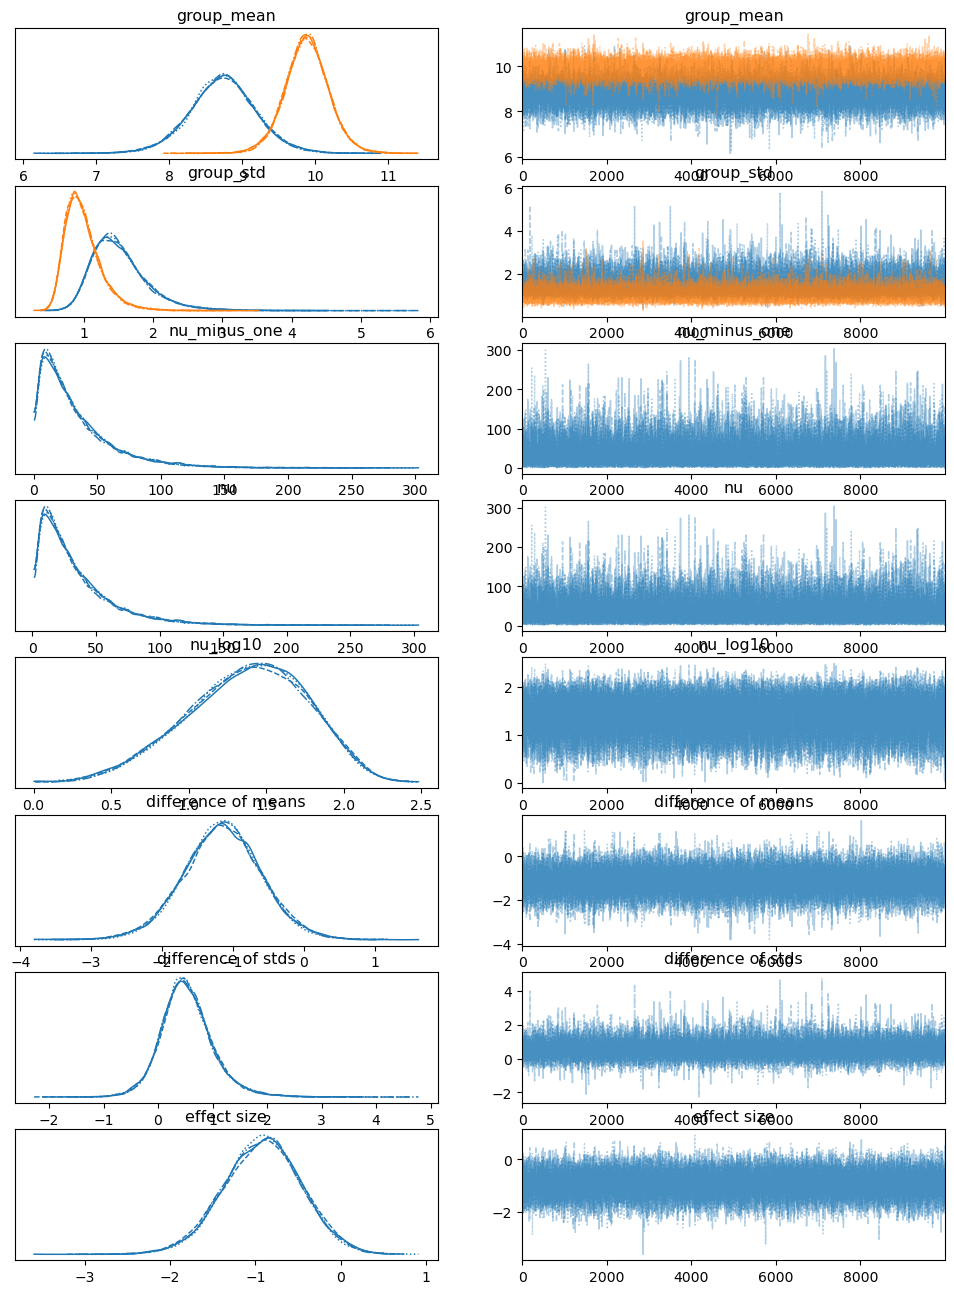

In [160]:
az.plot_trace(idata_lrn_e2);

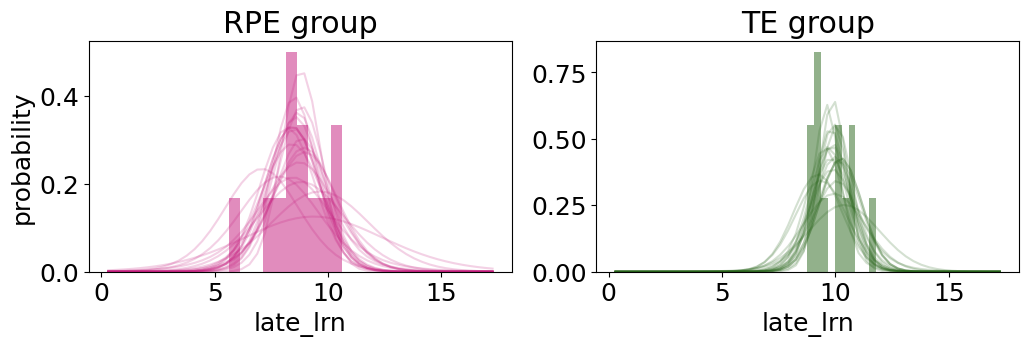

In [161]:
#Extract posterior
post = az.extract(idata_lrn_e2)

#Plot posterior predictive
plot_post_predictive_ttest(df2.late_lrn[df2.time=="Early"], 
                           df2.group[df2.time=="Early"], 
                           post, 
                           n_samps=20)

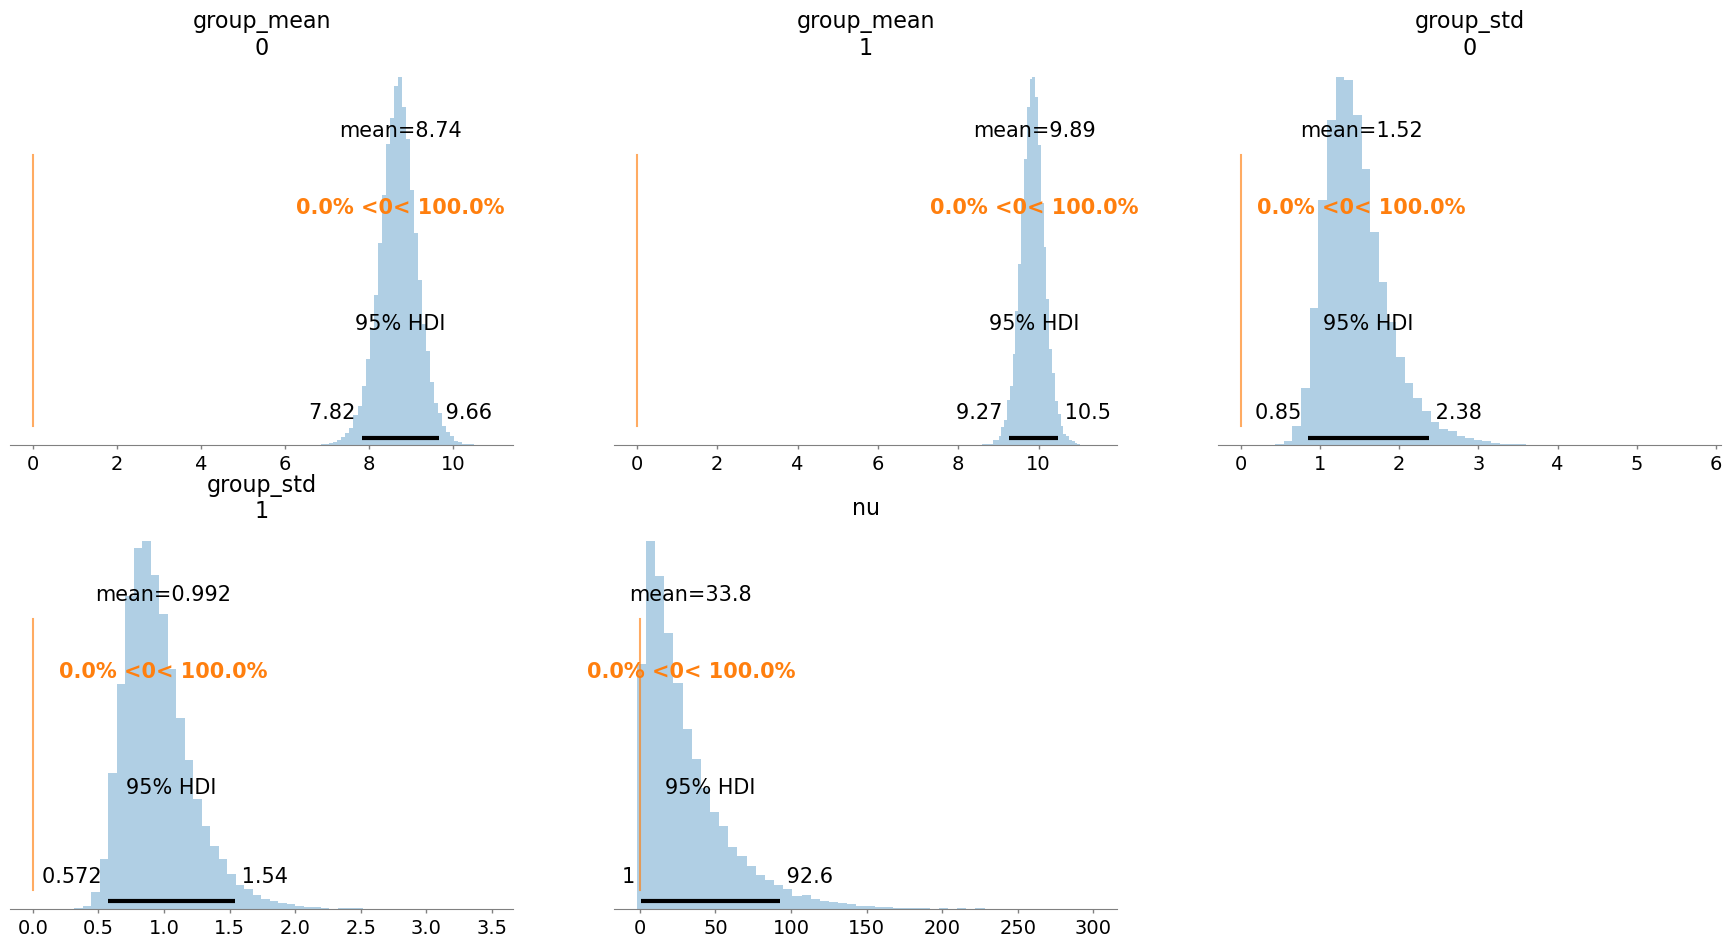

In [162]:
round_to = 3

az.plot_posterior(
    idata_lrn_e2,
    var_names=["group_mean", "group_std", "nu"],
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
    ref_val=0,
);

RPE mean = 8.74 [ 7.82 9.66 ]
TE mean = 9.89 [ 9.27 10.48 ]
Difference of means = -1.15 [ -2.24 -0.04 ]


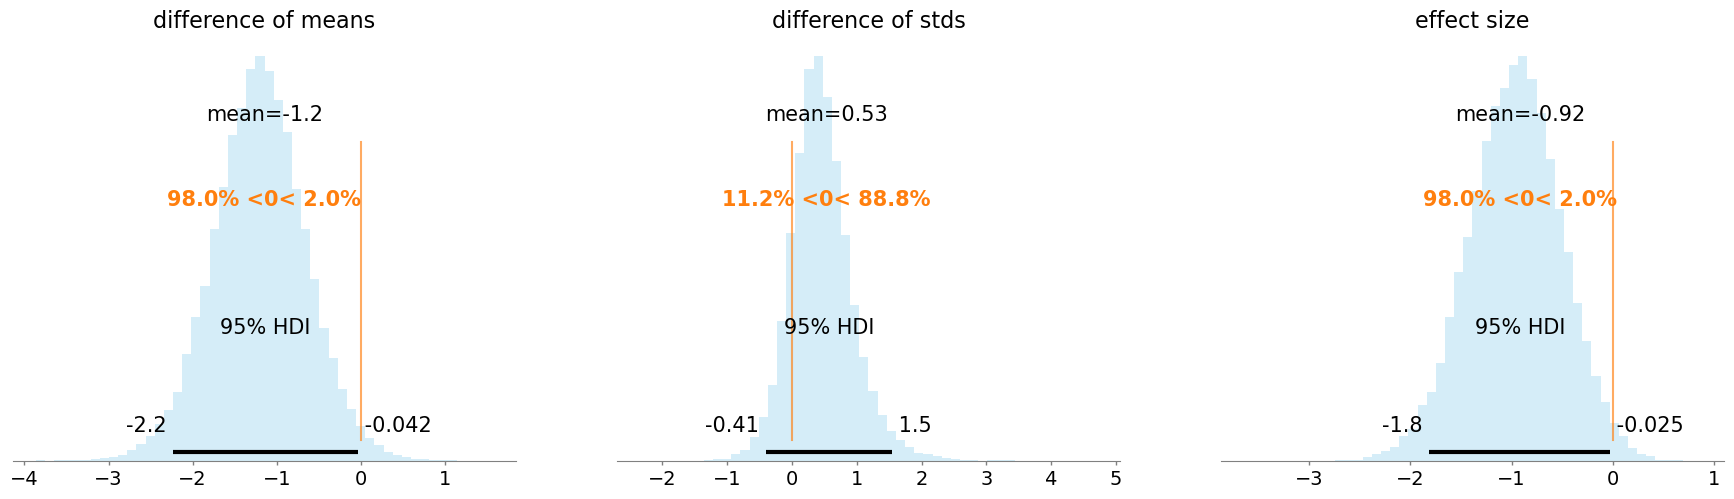

In [163]:
plot_post_simple_comparison(idata_lrn_e2, round_to=2)

## Learning Error

In [164]:
#Run the model
model_err_e2, idata_err_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                               within_subj_var=df2.time, 
                                                               subj_id=df2.subj_id, 
                                                               y=df2.error, 
                                                               n_draws=n_samples, rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 5588 seconds.


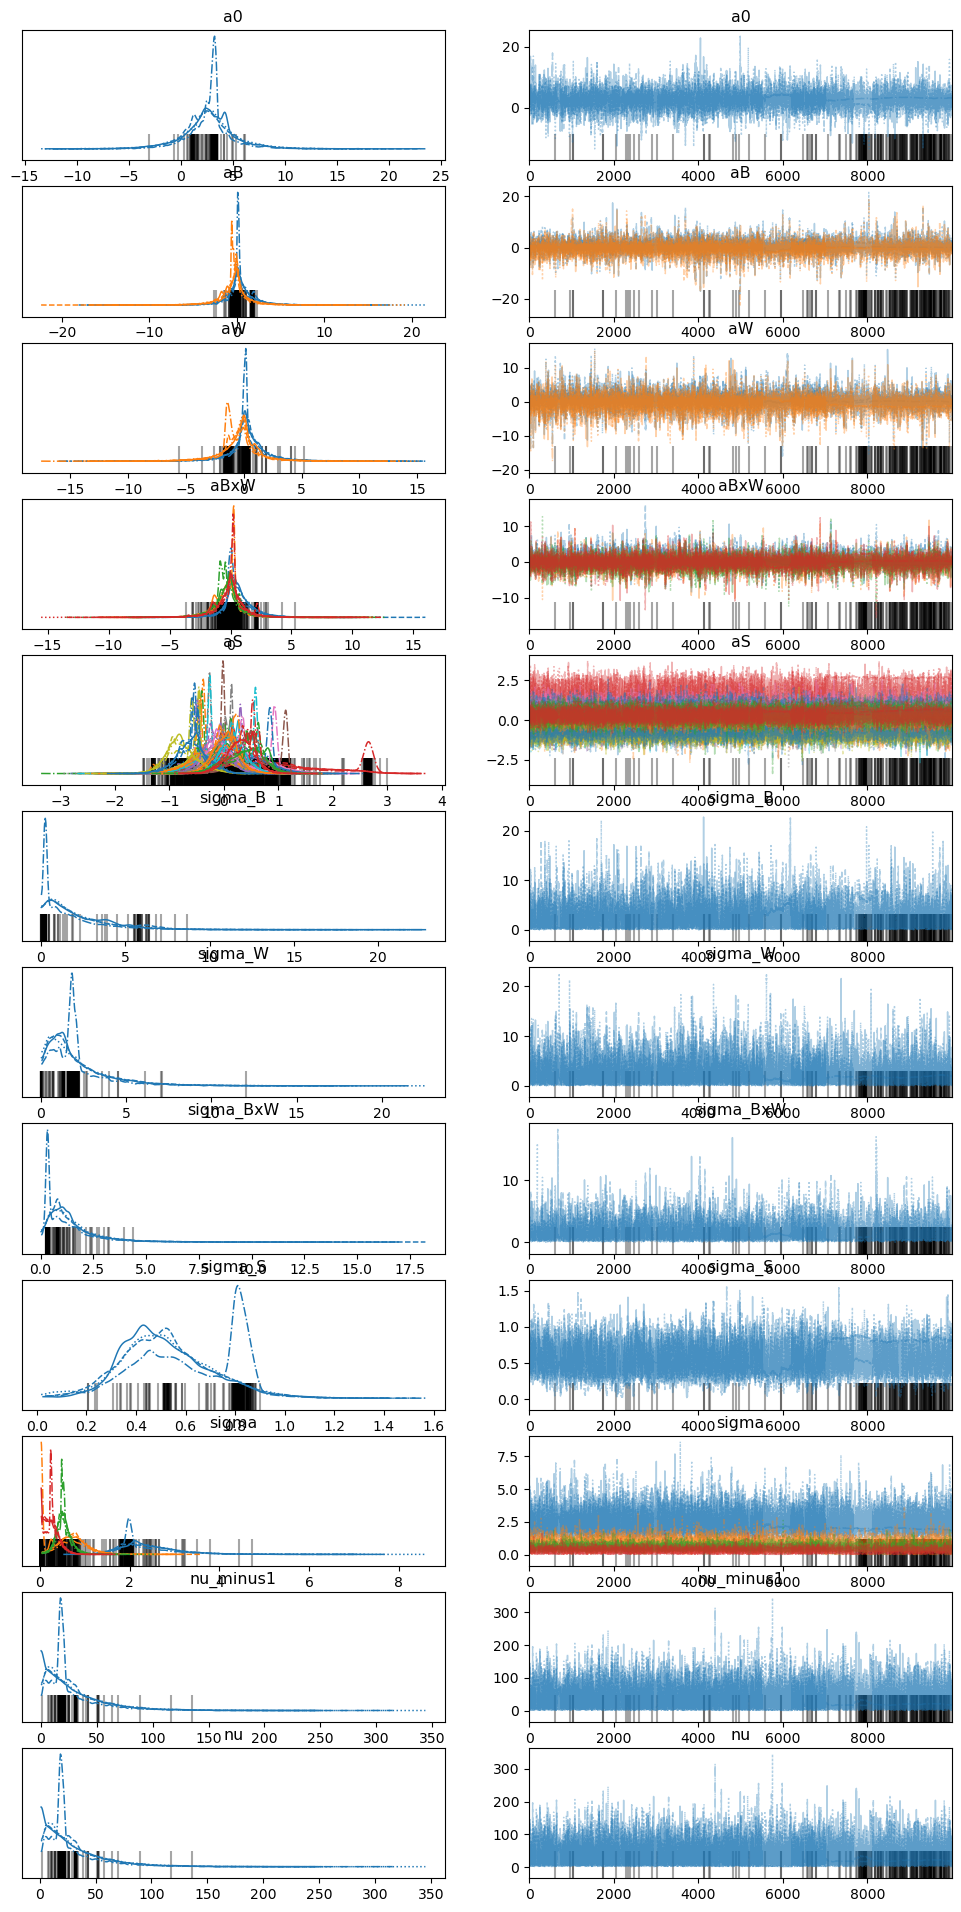

In [165]:
az.plot_trace(idata_err_e2);

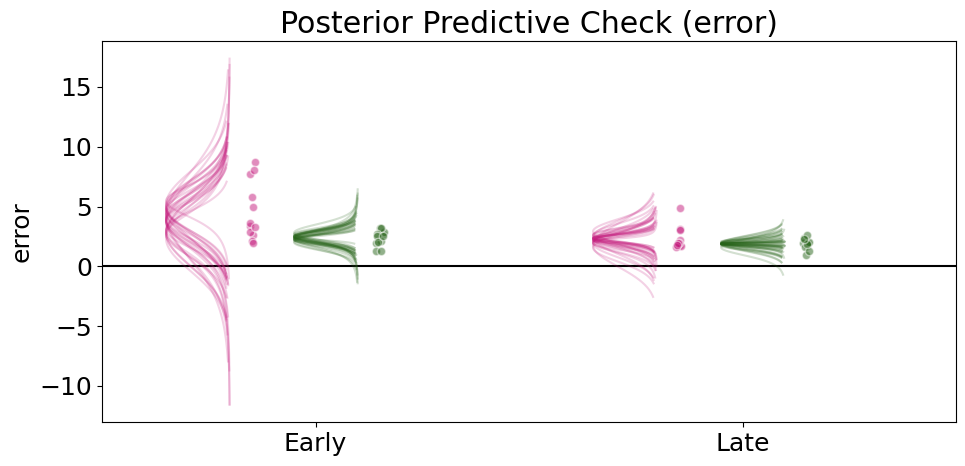

In [166]:
# Convert coefficients to sum-to-zero deflections
post_err_e2 = bst.convert_to_sum_to_zero(idata_err_e2, 
                                         df2.group, 
                                         df2.time, 
                                         df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova(between_subj=df2.group, 
                                within_subj=df2.time, 
                                y=df2.error, 
                                post=post_err_e2, 
                                n_mustaches=25)

Interactions:
Posterior for RPE Early = 4.04 [2.55 5.54]
Posterior for TE Early = 2.38 [2.05 2.72]
RPE vs TE @ Early = 1.66 [0.17 3.21]
 
Posterior for RPE Late = 2.3 [1.8  2.79]
Posterior for TE Late = 1.88 [1.68 2.08]
RPE vs TE @ Late = 0.42 [-0.11  0.93]
 


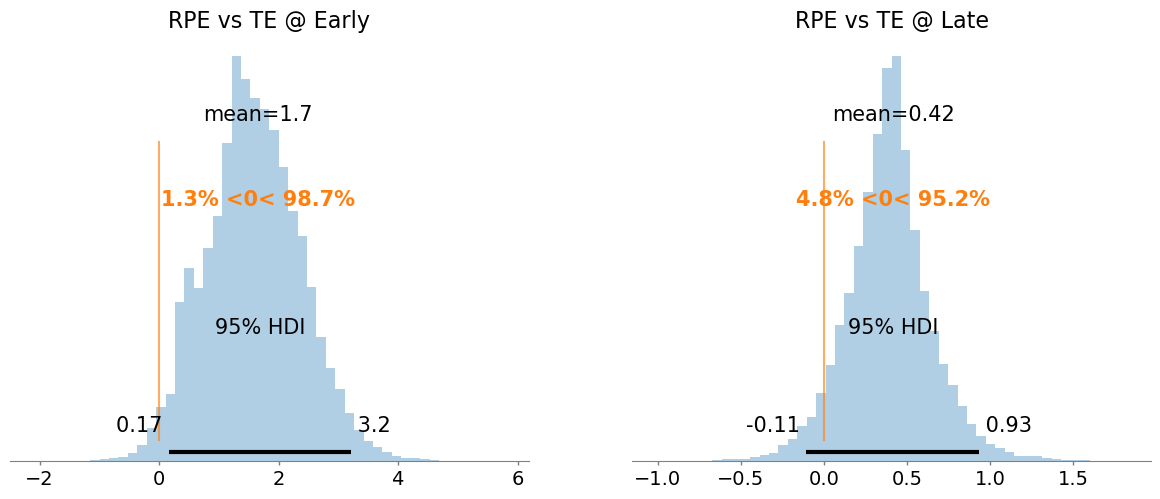

In [167]:
plot_between_contrasts(post_err_e2, round_to=2)

## Learning Percent success

In [168]:
#Run the model
model_success_e2, idata_success_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                                       within_subj_var=df2.time, 
                                                                       subj_id=df2.subj_id, 
                                                                       y=df2.success, 
                                                                       n_draws=n_samples, rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 4031 seconds.


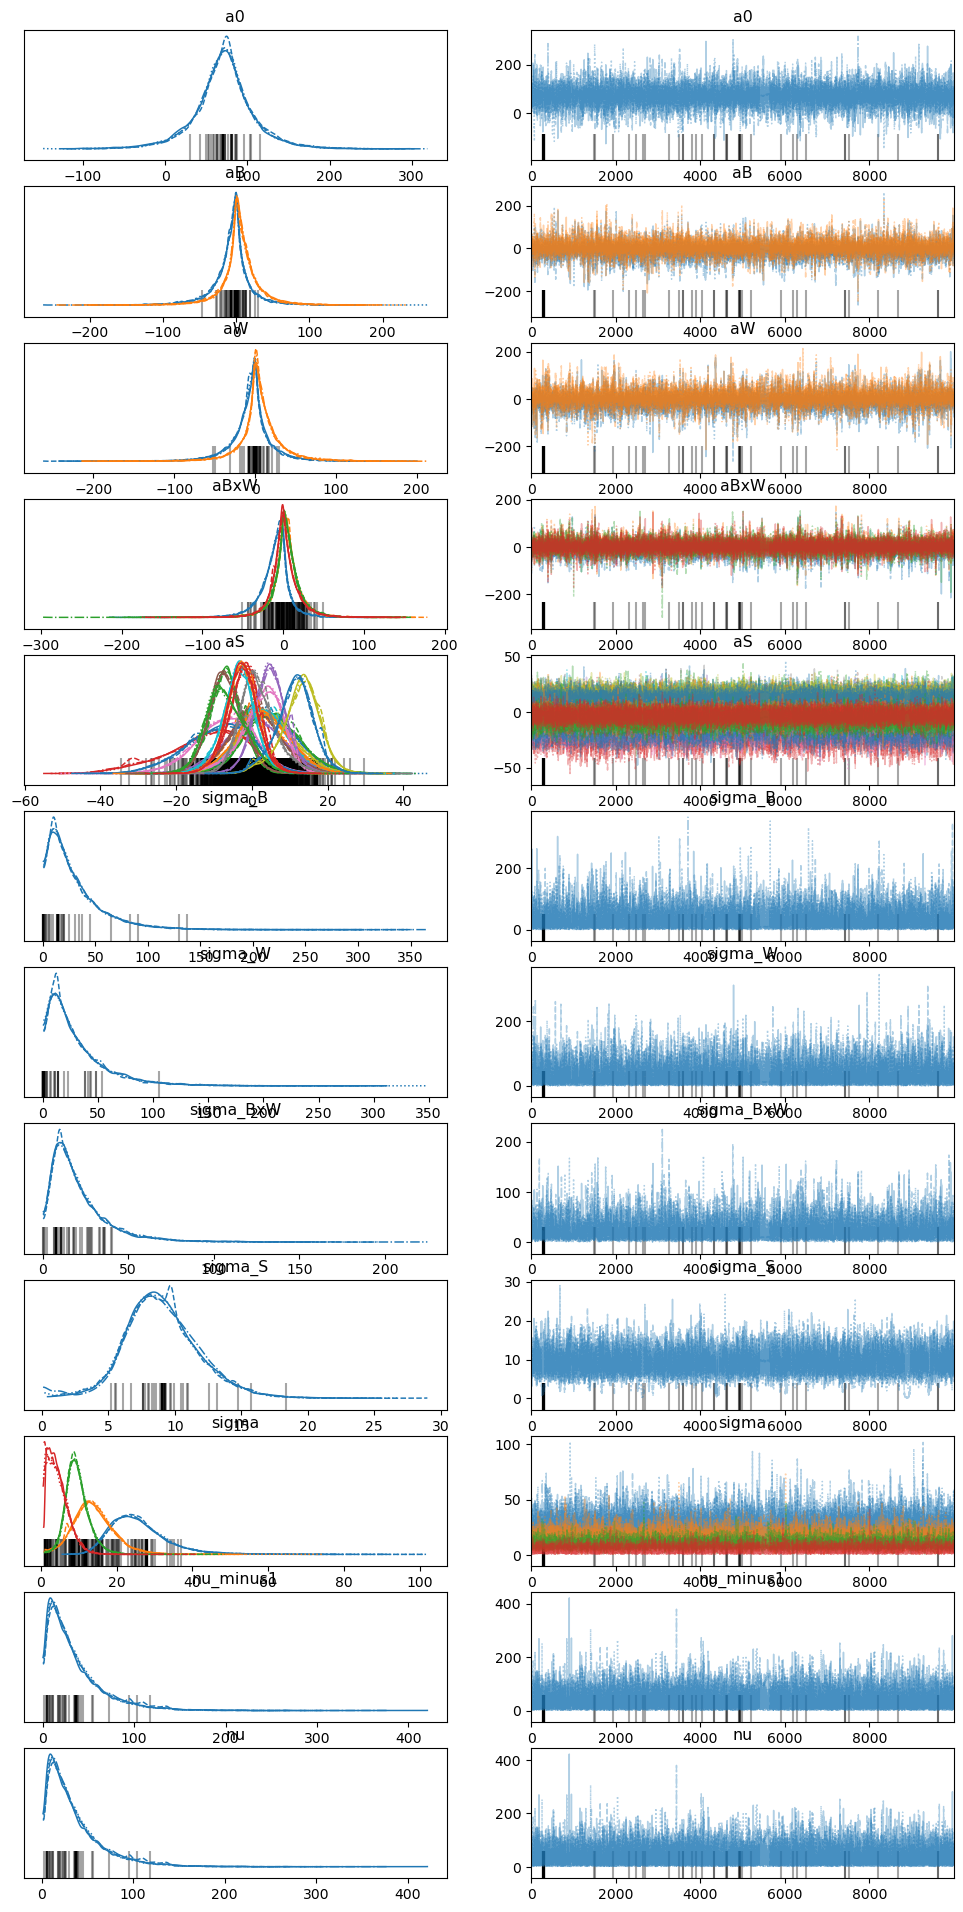

In [169]:
az.plot_trace(idata_success_e2);

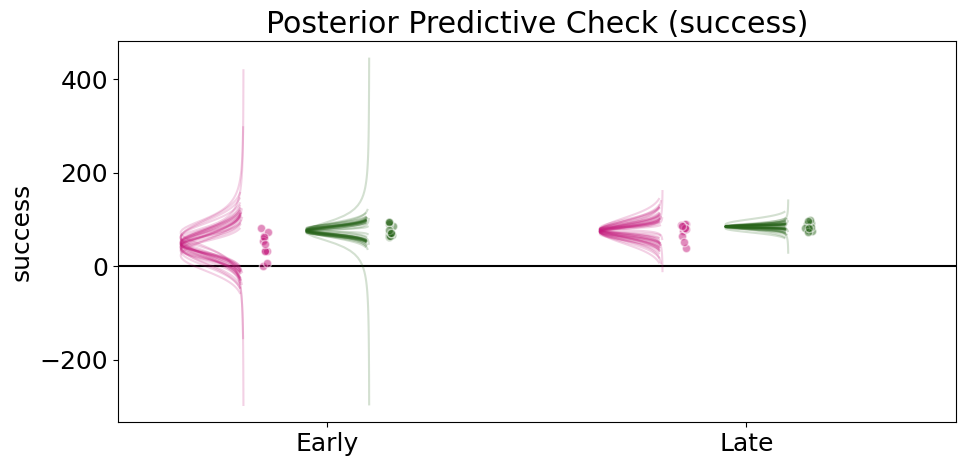

In [170]:
# Convert coefficients to sum-to-zero deflections
post_success_e2 = bst.convert_to_sum_to_zero(idata_success_e2, 
                                             df2.group, 
                                             df2.time, 
                                             df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova(between_subj=df2.group, 
                                within_subj=df2.time, 
                                y=df2.success, 
                                post=post_success_e2, 
                                n_mustaches=25)

Interactions:
Posterior for RPE Early = 49.8 [33.6 66.2]
Posterior for TE Early = 76.2 [70.  82.1]
RPE vs TE @ Early = -26.4 [-43.4  -8.8]
 
Posterior for RPE Late = 76.2 [67. 85.]
Posterior for TE Late = 85.2 [81.8 88.5]
RPE vs TE @ Late = -8.9 [-18.8   0.2]
 


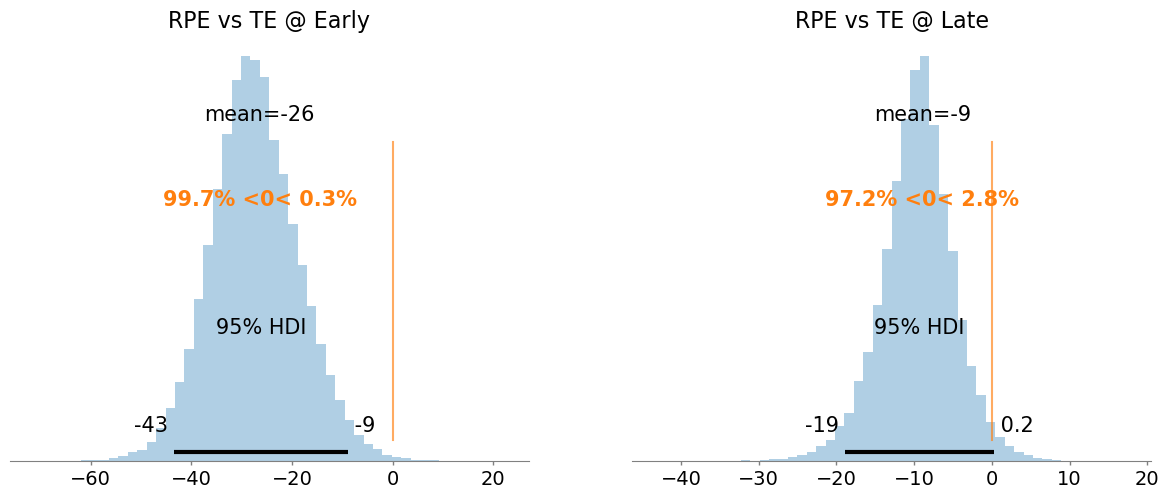

In [171]:
plot_between_contrasts(post_success_e2, round_to=1)

# Group comparisons during retention

In [172]:
#Run the model
model_ret_e2, idata_ret_e2 = robust_bayesian_mixed_model_anova(between_subj_var=df2.group, 
                                                               within_subj_var=df2.time, 
                                                               subj_id=df2.subj_id, 
                                                               y=df2.ret_prct, 
                                                               n_draws=n_samples, rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 1232 seconds.


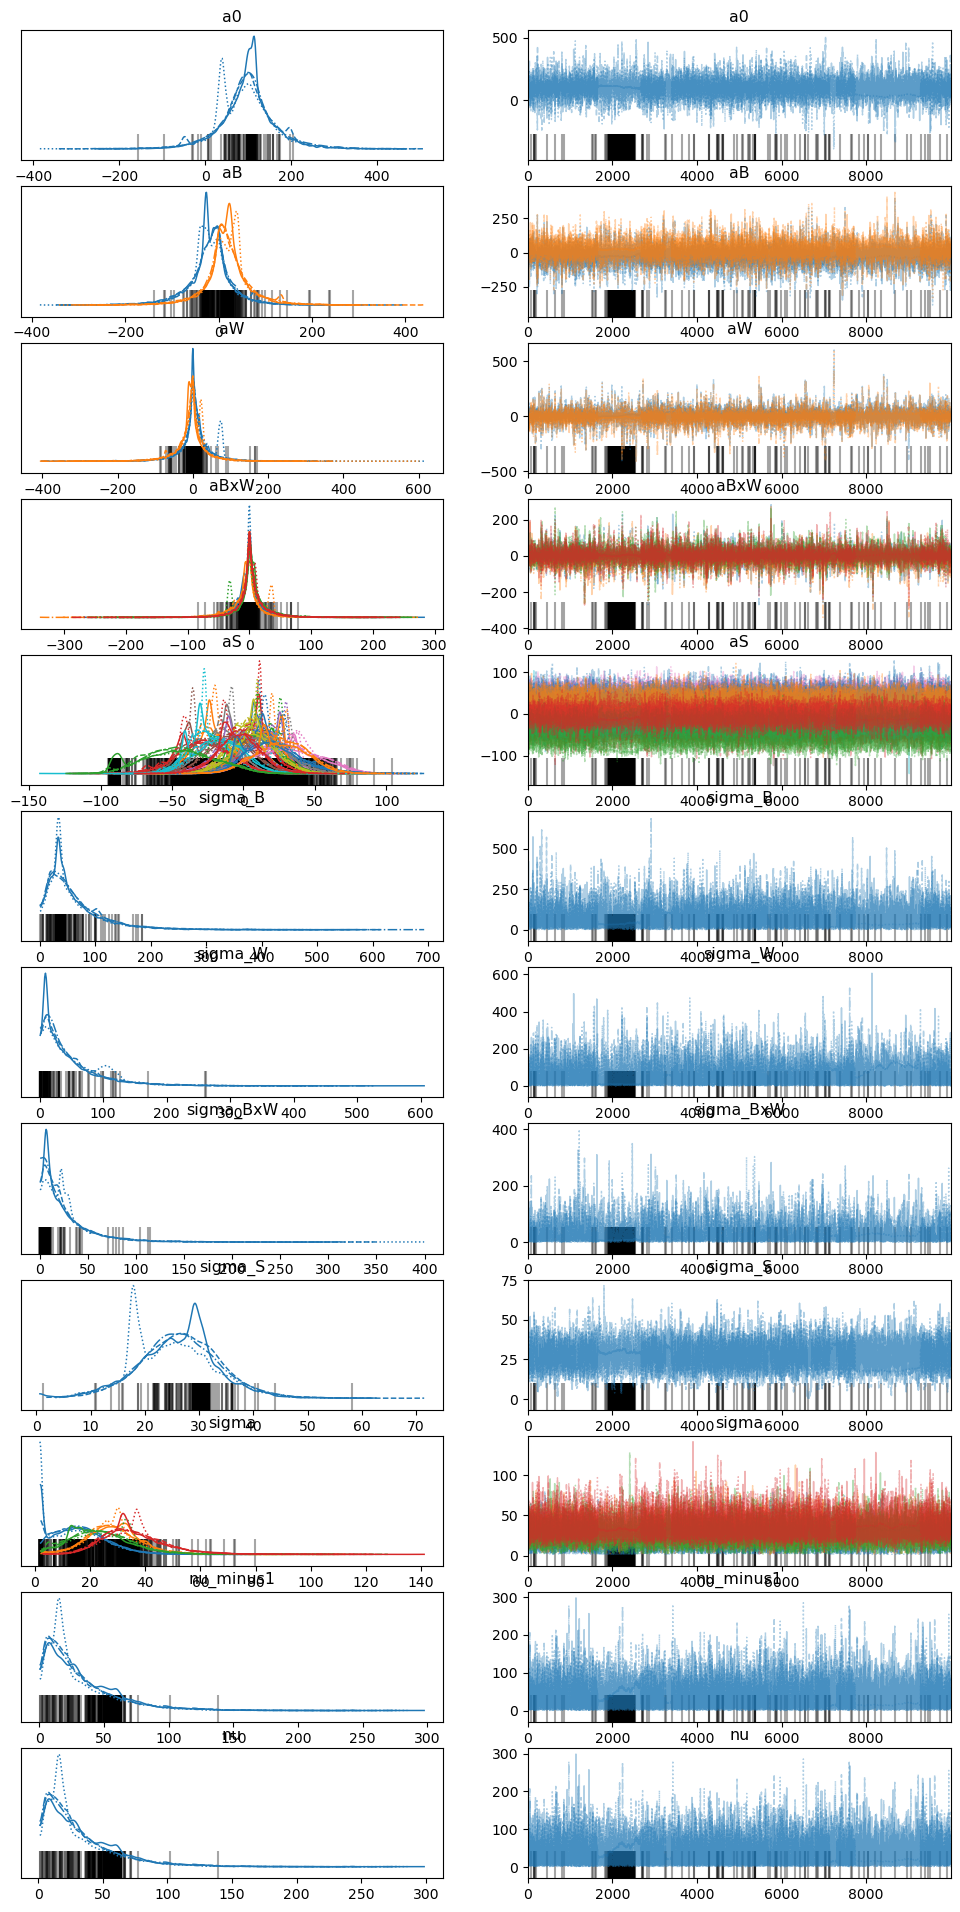

In [173]:
az.plot_trace(idata_ret_e2);

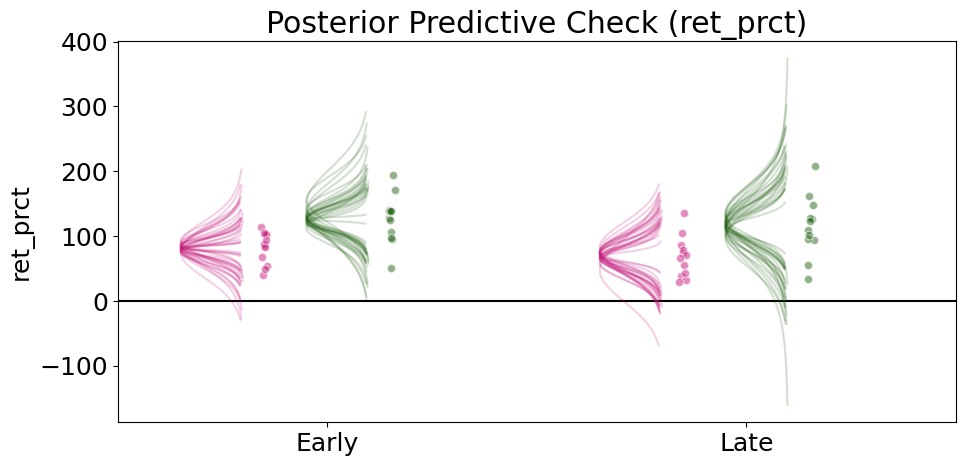

In [174]:
# Convert coefficients to sum-to-zero deflections
post_ret_e2 = bst.convert_to_sum_to_zero(idata_ret_e2, 
                                             df2.group, 
                                             df2.time, 
                                             df2.subj_id)

#Plot posterior predictive
plot_posterior_predictive_anova(between_subj=df2.group, 
                                within_subj=df2.time, 
                                y=df2.ret_prct, 
                                post=post_ret_e2, 
                                n_mustaches=25)

Interactions:
Posterior for RPE Early = 82.1 [69.9 93.4]
Posterior for TE Early = 126.3 [110.8 141.7]
RPE vs TE @ Early = -44.3 [-62.2 -25.3]
 
Posterior for RPE Late = 68.8 [51.6 85.6]
Posterior for TE Late = 114.2 [ 94.2 135.2]
RPE vs TE @ Late = -45.4 [-69.7 -19.7]
 


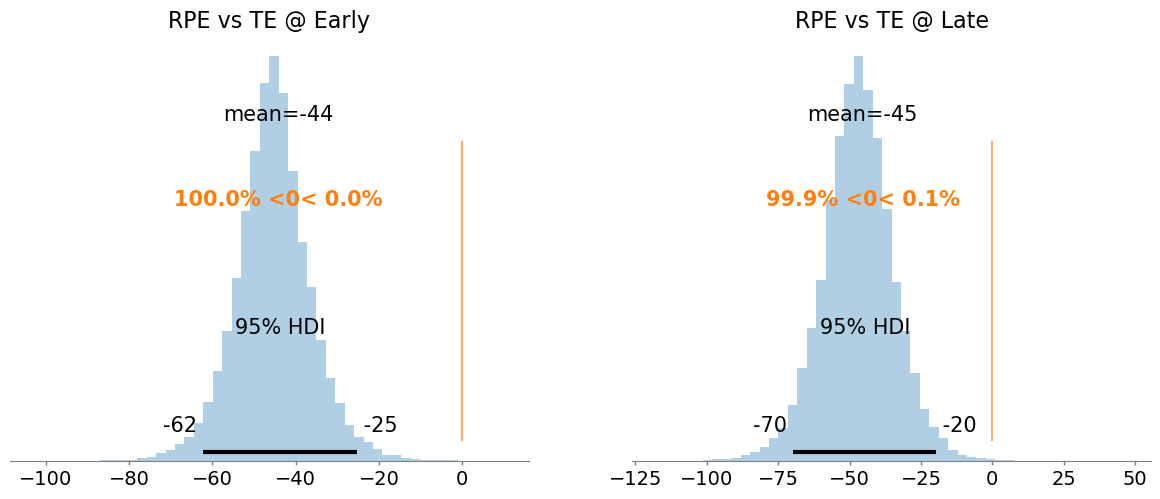

In [175]:
plot_between_contrasts(post_ret_e2, round_to=1)

Within subject contrasts:
RPE Early vs RPE Late = 13.3 [-6.1 33.2]


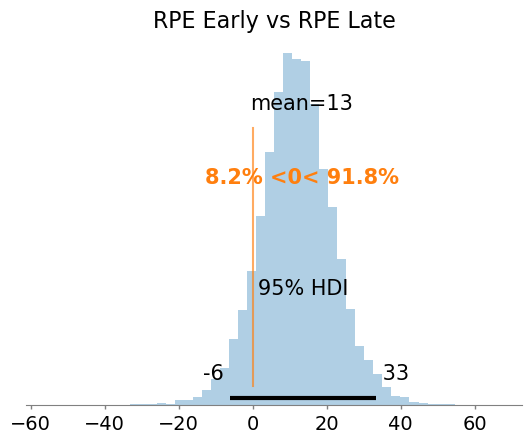

In [ ]:
plot_within_contrasts(post_ret_e2, round_to=1, between_factor='RPE')

Within subject contrasts:
TE Early vs TE Late = 12.1 [-11.1  36.8]


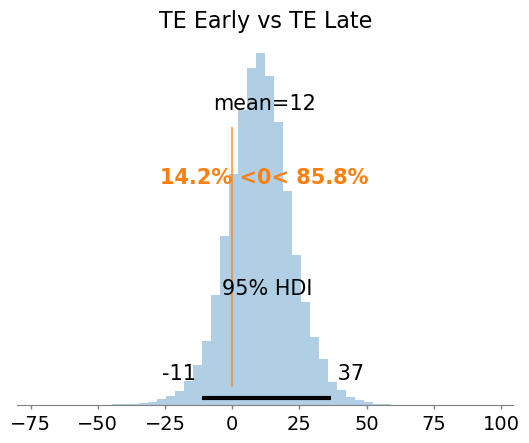

In [ ]:
plot_within_contrasts(post_ret_e2, round_to=1, between_factor='TE')

Within subject main effects:
Early vs Late = 12.7 [-3.6 29.5]


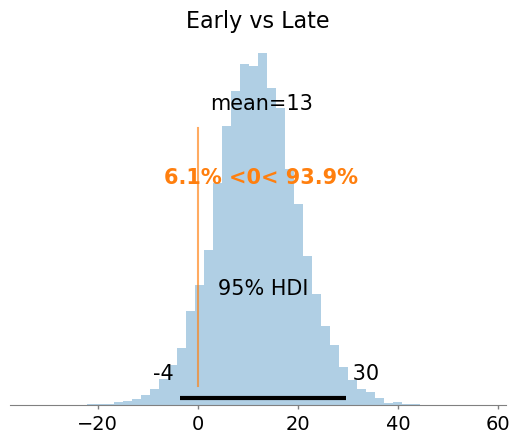

In [ ]:
plot_main_effect_within(post_ret_e2, round_to=1)

## Regression - reward and late learning

### 5 minutes

In [254]:
X = df2_regress[["success", "late_lrn", "group"]]
y = df2_regress["retention_5"]
model_ret5_regress, idata_ret5_regress = robust_multiple_linear_regression(X=X,
                                                                           y=y, 
                                                                           n_draws=n_samples,
                                                                           rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbeta, nu_minus_one, nu, zsigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 36 seconds.


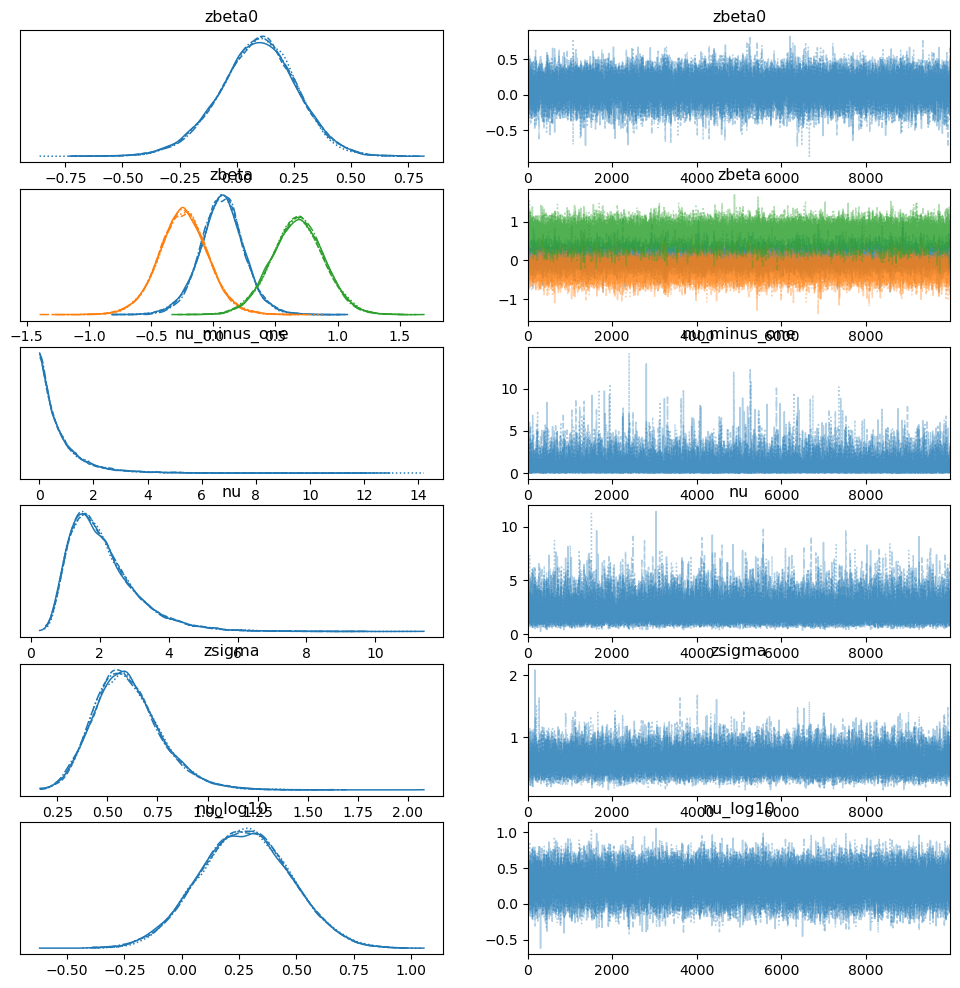

In [255]:
az.plot_trace(idata_ret5_regress);

In [256]:
post_ret5_regress = az.extract(idata_ret5_regress.posterior)
# Return parameters to raw data scale
post_ret5_regress["beta0"], post_ret5_regress["beta"], post_ret5_regress["sigma"] = bst.unstandardize_multiple_linreg_parameters(
    post_ret5_regress["zbeta0"], post_ret5_regress["zbeta"], post_ret5_regress["zsigma"], X, y)

Posterior for intercept = 132.01 [ 33.58 242.02]
Posterior for success = 0.21 [-0.91  1.29]
Posterior for late_lrn = -6.95 [-18.39   4.91]
Posterior for group = 50.92 [19.46 82.35]


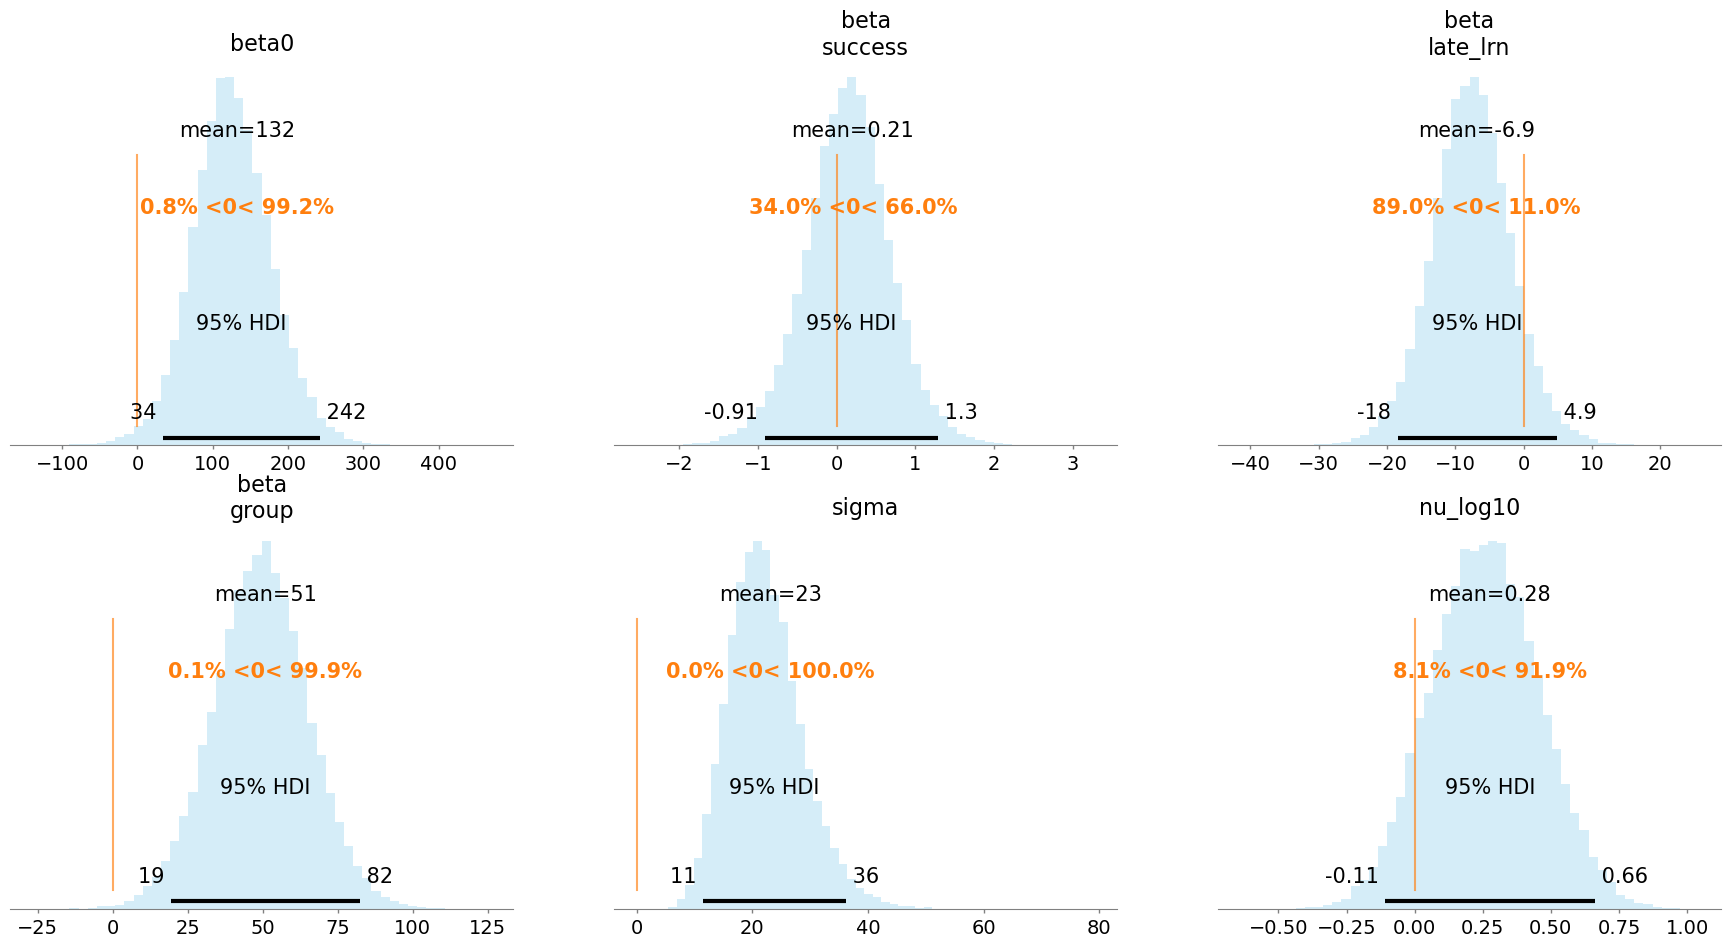

In [257]:
plot_post_regress(post_ret5_regress, round_to=2)

### 24 hours

In [258]:
X = df2_regress[["success", "late_lrn", "group"]]
y = df2_regress["retention_24"]
model_ret24_regress, idata_ret24_regress = robust_multiple_linear_regression(X=X,
                                                                             y=y, 
                                                                             n_draws=n_samples,
                                                                             rnd_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbeta, nu_minus_one, nu, zsigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 38 seconds.


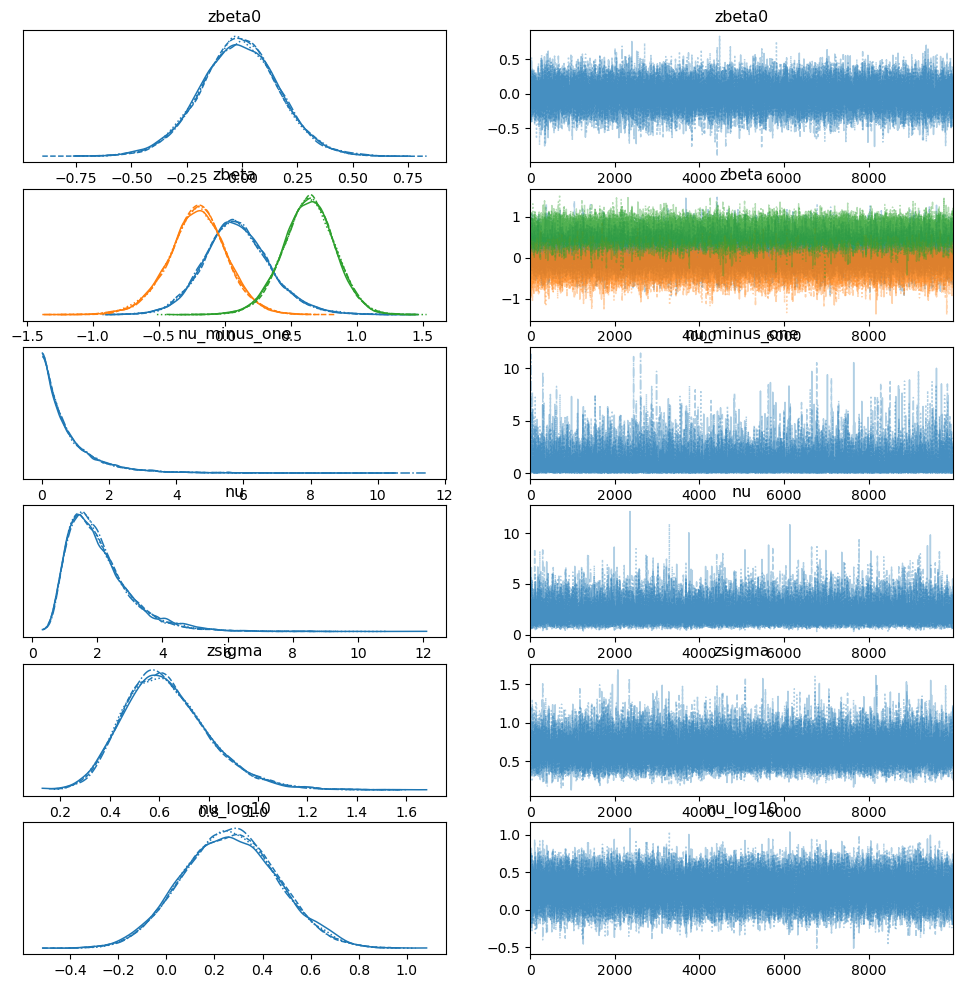

In [259]:
az.plot_trace(idata_ret24_regress);

In [260]:
post_ret24_regress = az.extract(idata_ret24_regress.posterior)
# Return parameters to raw data scale
post_ret24_regress["beta0"], post_ret24_regress["beta"], post_ret24_regress["sigma"] = bst.unstandardize_multiple_linreg_parameters(
    post_ret24_regress["zbeta0"], post_ret24_regress["zbeta"], post_ret24_regress["zsigma"], X, y)

Posterior for intercept = 104.11 [-39.92 251.04]
Posterior for success = 0.34 [-1.45  2.26]
Posterior for late_lrn = -7.15 [-22.7    8.32]
Posterior for group = 56.82 [22.19 92.22]


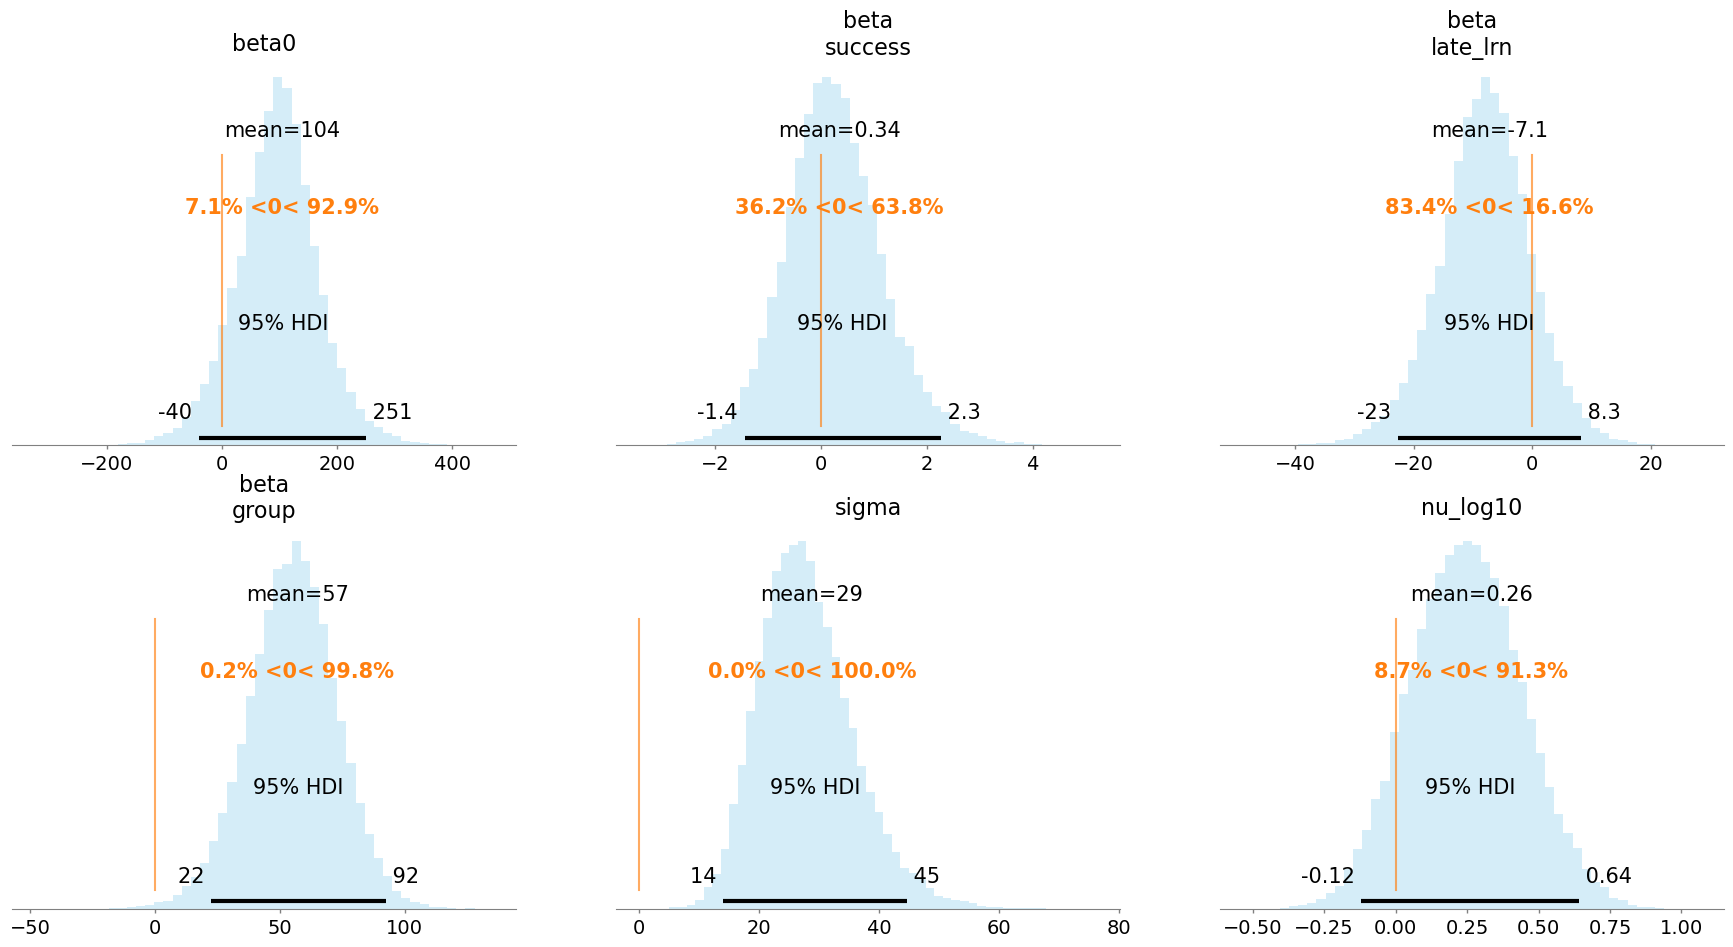

In [261]:
plot_post_regress(post_ret24_regress, round_to=2)

## Cognitive biases

### Differnece between groups?

In [153]:
y, levels_y, num_levels_y = bst.parse_categorical(df2_regress.SLpercept)
levels_y #Longer=0, No change = 1, slightly longer = 2

#Create a y for each model
#Longer=0, No change = 1, slightly longer = 2
y_longer = y==0
y_nochange = y==1
y_slight = y==2

In [140]:
model_longer, idata_longer = bst.bayesian_logreg_subj_intercepts(df2_regress.subj_id, 
                                                                 df2_regress.group, 
                                                                 y_longer)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


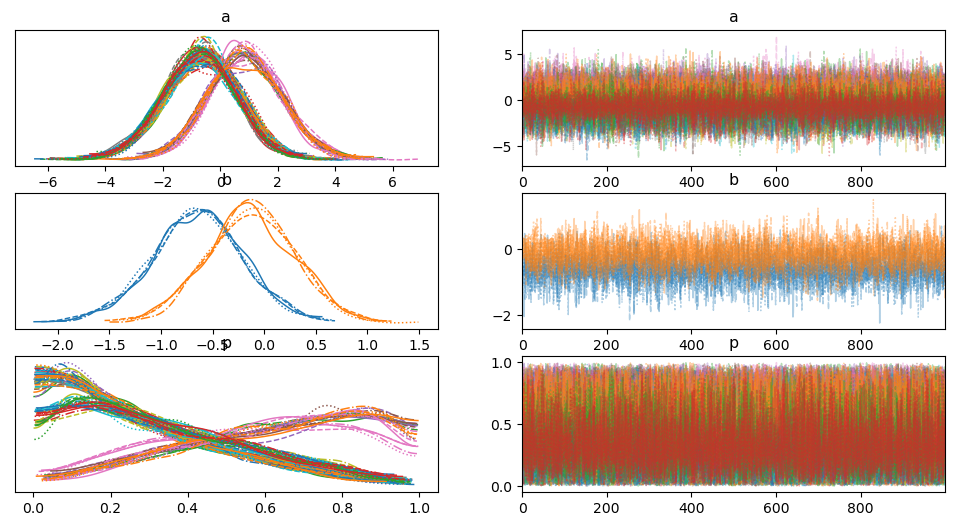

In [141]:
az.plot_trace(idata_longer);

In [142]:
model_nochange, idata_nochange = bst.bayesian_logreg_subj_intercepts(df2_regress.subj_id, 
                                                                     df2_regress.group, 
                                                                     y_nochange)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


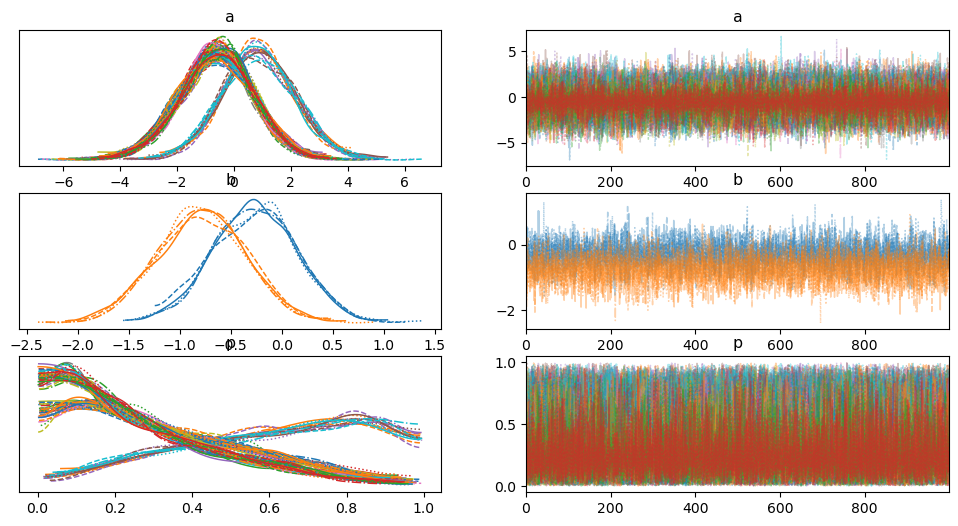

In [143]:
az.plot_trace(idata_nochange);

In [144]:
model_slight, idata_slight = bst.bayesian_logreg_subj_intercepts(df2_regress.subj_id, 
                                                             df2_regress.group, 
                                                             y_slight)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


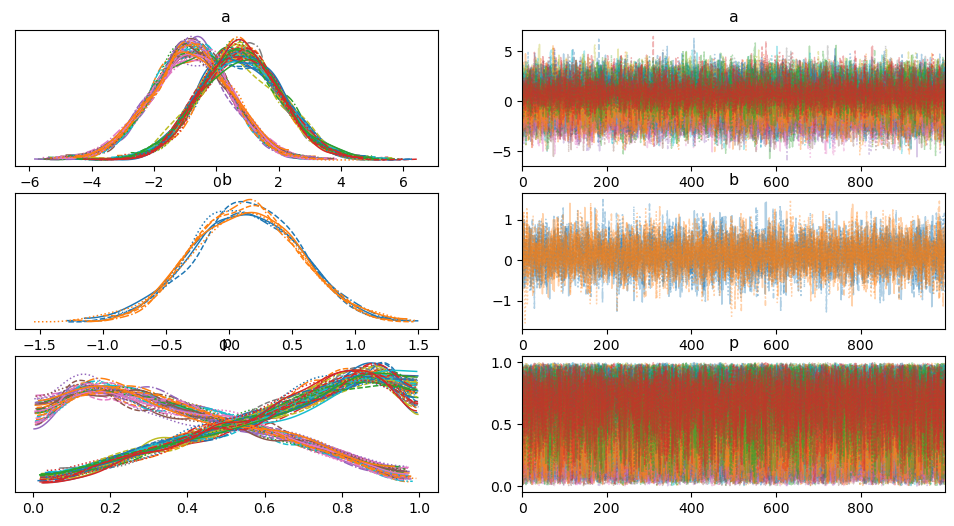

In [145]:
az.plot_trace(idata_slight);

In [148]:
az.summary(idata_slight, var_names=['b'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[RPE]  0.135  0.422  -0.644    0.930      0.004    0.006   10353.0    3545.0   
b[TE]   0.131  0.425  -0.655    0.925      0.004    0.007    9516.0    3017.0   

        r_hat  
b[RPE]    1.0  
b[TE]     1.0

In [149]:
az.summary(idata_longer, var_names=['b'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[RPE] -0.651  0.440  -1.462    0.227      0.004    0.004   10202.0    3200.0   
b[TE]  -0.132  0.424  -0.948    0.640      0.005    0.006    8208.0    3140.0   

        r_hat  
b[RPE]    1.0  
b[TE]     1.0

In [150]:
az.summary(idata_nochange, var_names=['b'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[RPE] -0.263  0.417  -1.058    0.508      0.005    0.005    8562.0    3423.0   
b[TE]  -0.787  0.433  -1.602   -0.004      0.005    0.004    8526.0    3496.0   

        r_hat  
b[RPE]    1.0  
b[TE]     1.0

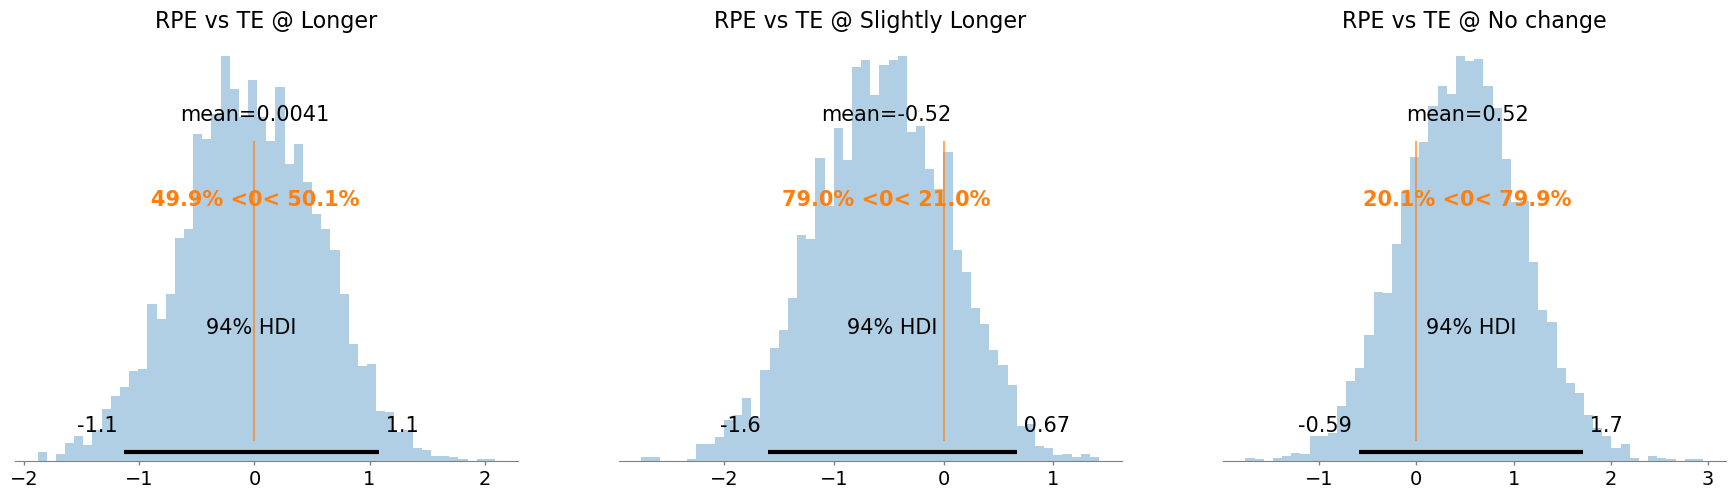

In [151]:
post_slight = az.extract(idata_slight.posterior)
post_longer = az.extract(idata_longer.posterior)
post_nochange = az.extract(idata_nochange.posterior)

contrasts = {"RPE vs TE @ Longer": post_slight.b.sel(treatment='RPE') - post_slight.b.sel(treatment='TE'),
             "RPE vs TE @ Slightly Longer": post_longer.b.sel(treatment='RPE') - post_longer.b.sel(treatment='TE'),
             "RPE vs TE @ No change": post_nochange.b.sel(treatment='RPE') - post_nochange.b.sel(treatment='TE')
            }
az.plot_posterior(contrasts,
                 kind='hist',
                 bins=50,
                 ref_val=0);

### 5 minutes

In [309]:
x_prcpt, levels_x_prcpt, num_levels_x_prcpt = bst.parse_categorical(df2_regress.SLpercept)
x_grp, levels_x_grp, num_levels_x_grp = bst.parse_categorical(df2_regress.group)
x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(df2_regress.subj_id)

In [313]:
with pm.Model(coords={
                      "group": levels_x_grp,
                      "perception": levels_x_prcpt
                      }) as model_ret5_cog:
    
    # Define priors
    beta0 = pm.Normal("beta0", mu=100, sigma=200)
    # beta_lrn = pm.Normal("beta_lrn", mu=100, sigma=200)
    # beta_rwd = pm.Normal("beta_rwd", mu=100, sigma=200)
    beta_grp = pm.Normal("beta_grp", mu=100, sigma=200, dims='group')
    beta_prcpt = pm.Normal("beta_prcpt", mu=100, sigma=200, dims='perception')

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
    nu = pm.Exponential("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    # mu = beta0 + beta_lrn*df2_regress.late_lrn + beta_rwd*df2_regress.success + beta_grp[df2_regress.group] + beta_prcpt[x_prcpt]
    mu = beta0 + beta_grp[x_grp] + beta_prcpt[x_prcpt]
    sigma = pm.Uniform("sigma", 10**-5, 300)

    # Define likelihood
    likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, lam=1 / sigma**2, observed=df2_regress["retention_5"])

    # Sample the posterior
    idata_ret5_cog = pm.sample(draws=n_samples, tune=2000, random_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta_grp, beta_prcpt, nu_minus_one, nu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 277 seconds.


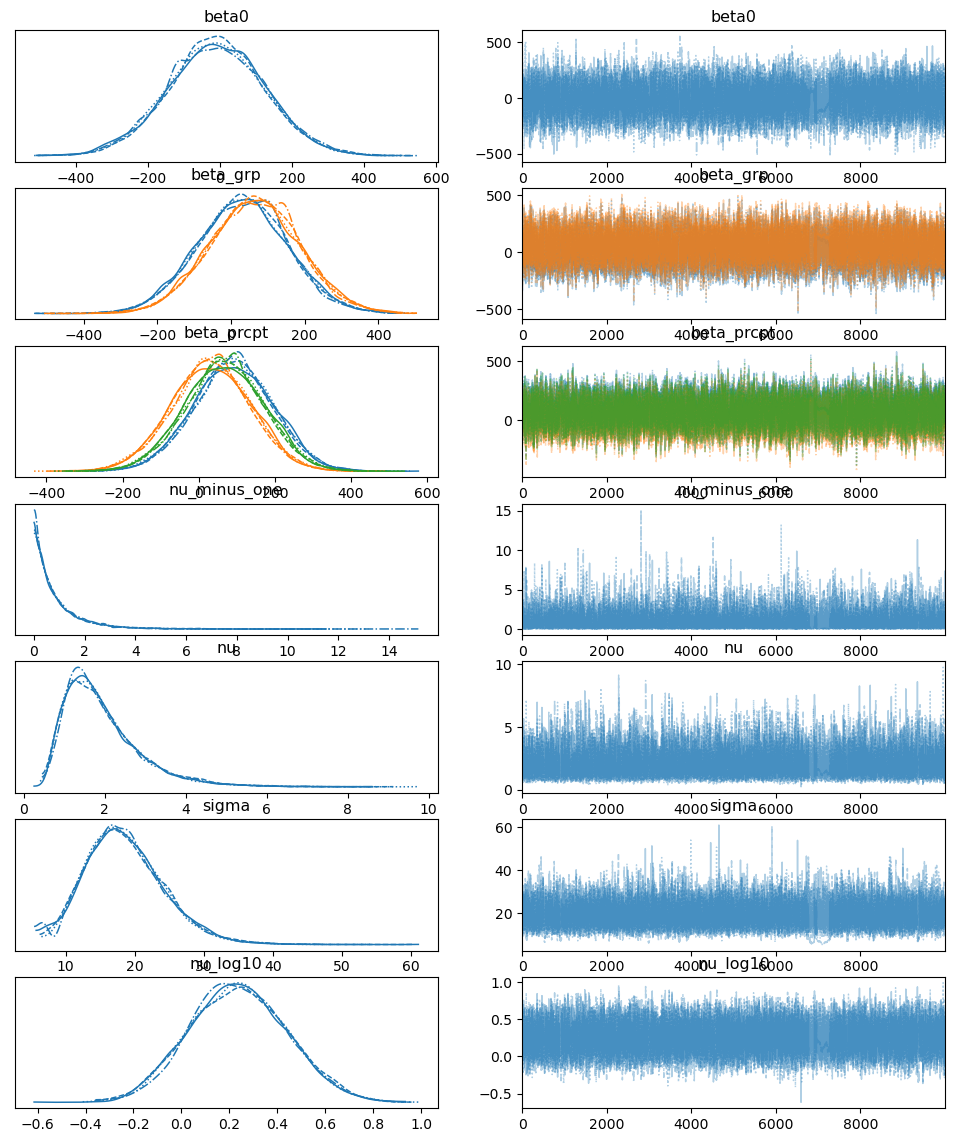

In [314]:
az.plot_trace(idata_ret5_cog);

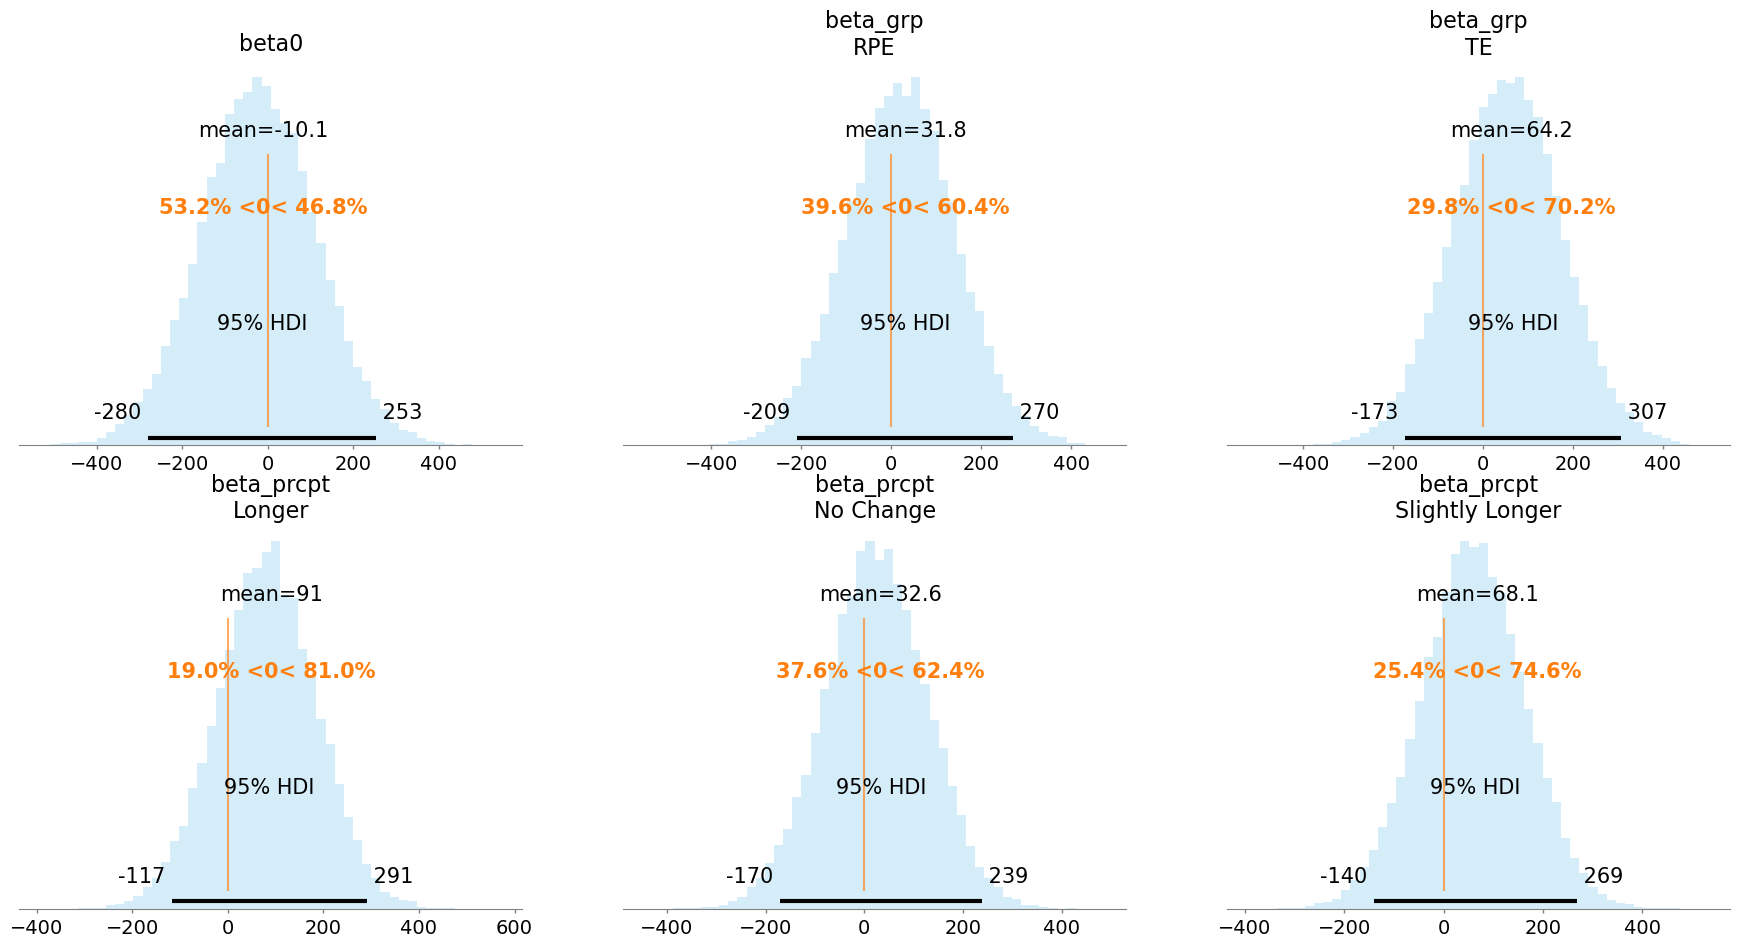

In [329]:
post_ret5_cog = az.extract(idata_ret5_cog.posterior)

az.plot_posterior(
    post_ret5_cog,
    var_names=["beta0", "beta_grp", "beta_prcpt"],
    combine_dims={"sample"}, 
    point_estimate="mean",
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
);

In [328]:
longer_hdi = az.hdi(post_ret5_cog.beta_prcpt.sel(perception='Longer').values, hdi_prob=0.95, combine_dims={"sample"})
slight_hdi = az.hdi(post_ret5_cog.beta_prcpt.sel(perception='Slightly Longer').values, hdi_prob=0.95, combine_dims={"sample"})
nc_hdi = az.hdi(post_ret5_cog.beta_prcpt.sel(perception='No Change').values, hdi_prob=0.95, combine_dims={"sample"})

print('beta longer posterior =', np.round(np.mean(post_ret5_cog.beta_prcpt.sel(perception='Longer').values),round_to), np.round(longer_hdi,round_to))
print('beta slightly longer posterior =', np.round(np.mean(post_ret5_cog.beta_prcpt.sel(perception='Slightly Longer').values),round_to), np.round(slight_hdi,round_to))
print('beta no change posterior =', np.round(np.mean(post_ret5_cog.beta_prcpt.sel(perception='No Change').values),round_to), np.round(nc_hdi,round_to))


beta longer posterior = 90.979 [-117.22   291.276]
beta slightly longer posterior = 68.098 [-139.531  268.802]
beta no change posterior = 32.596 [-170.486  239.238]


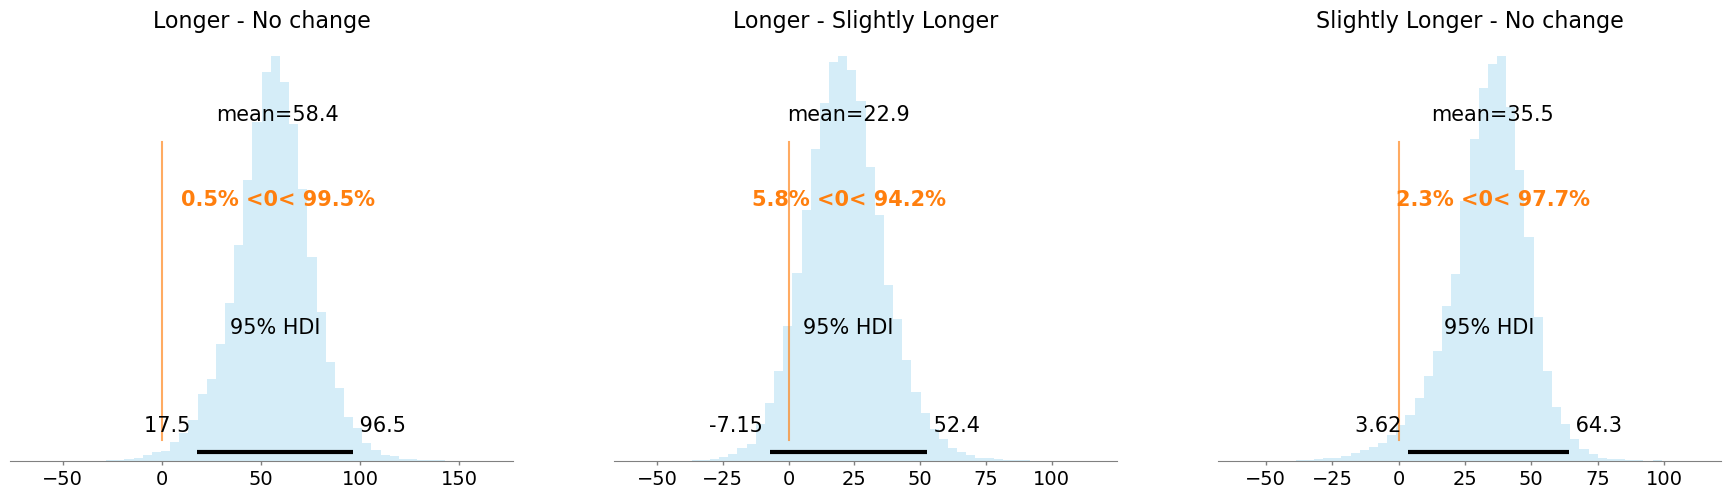

In [325]:
#Build contrasts
contrast = {"Longer - No change": post_ret5_cog.beta_prcpt.sel(perception='Longer') - post_ret5_cog.beta_prcpt.sel(perception='No Change'),
            "Longer - Slightly Longer": post_ret5_cog.beta_prcpt.sel(perception='Longer') - post_ret5_cog.beta_prcpt.sel(perception='Slightly Longer'),
            "Slightly Longer - No change": post_ret5_cog.beta_prcpt.sel(perception='Slightly Longer') - post_ret5_cog.beta_prcpt.sel(perception='No Change')
           }

az.plot_posterior(
    contrast,
    combine_dims={"sample"}, 
    point_estimate="mean",
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
);

### 24 hour

In [316]:
with pm.Model(coords={
                      "group": levels_x_grp,
                      "perception": levels_x_prcpt
                      }) as model_ret24_cog:
    
    # Define priors
    beta0 = pm.Normal("beta0", mu=100, sigma=200)
    # beta_lrn = pm.Normal("beta_lrn", mu=100, sigma=200)
    # beta_rwd = pm.Normal("beta_rwd", mu=100, sigma=200)
    beta_grp = pm.Normal("beta_grp", mu=100, sigma=200, dims='group')
    beta_prcpt = pm.Normal("beta_prcpt", mu=100, sigma=200, dims='perception')

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
    nu = pm.Exponential("nu", nu_minus_one + 1)
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    # mu = beta0 + beta_lrn*df2_regress.late_lrn + beta_rwd*df2_regress.success + beta_grp[df2_regress.group] + beta_prcpt[x_prcpt]
    mu = beta0 + beta_grp[x_grp] + beta_prcpt[x_prcpt]
    sigma = pm.Uniform("sigma", 10**-5, 300)

    # Define likelihood
    likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, lam=1 / sigma**2, observed=df2_regress["retention_24"])

    # Sample the posterior
    idata_ret24_cog = pm.sample(draws=n_samples, tune=2000, random_seed=seed_num)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta_grp, beta_prcpt, nu_minus_one, nu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 173 seconds.


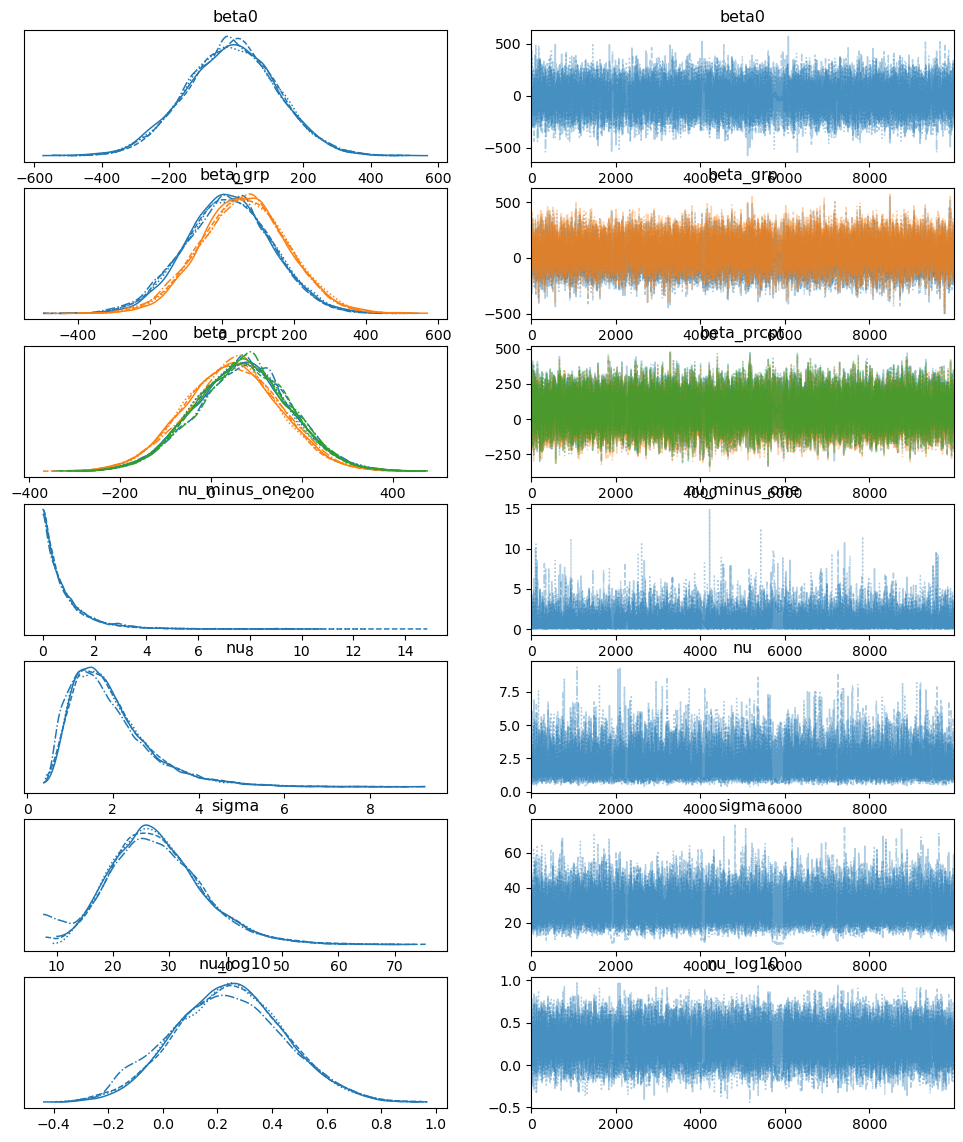

In [317]:
az.plot_trace(idata_ret24_cog);

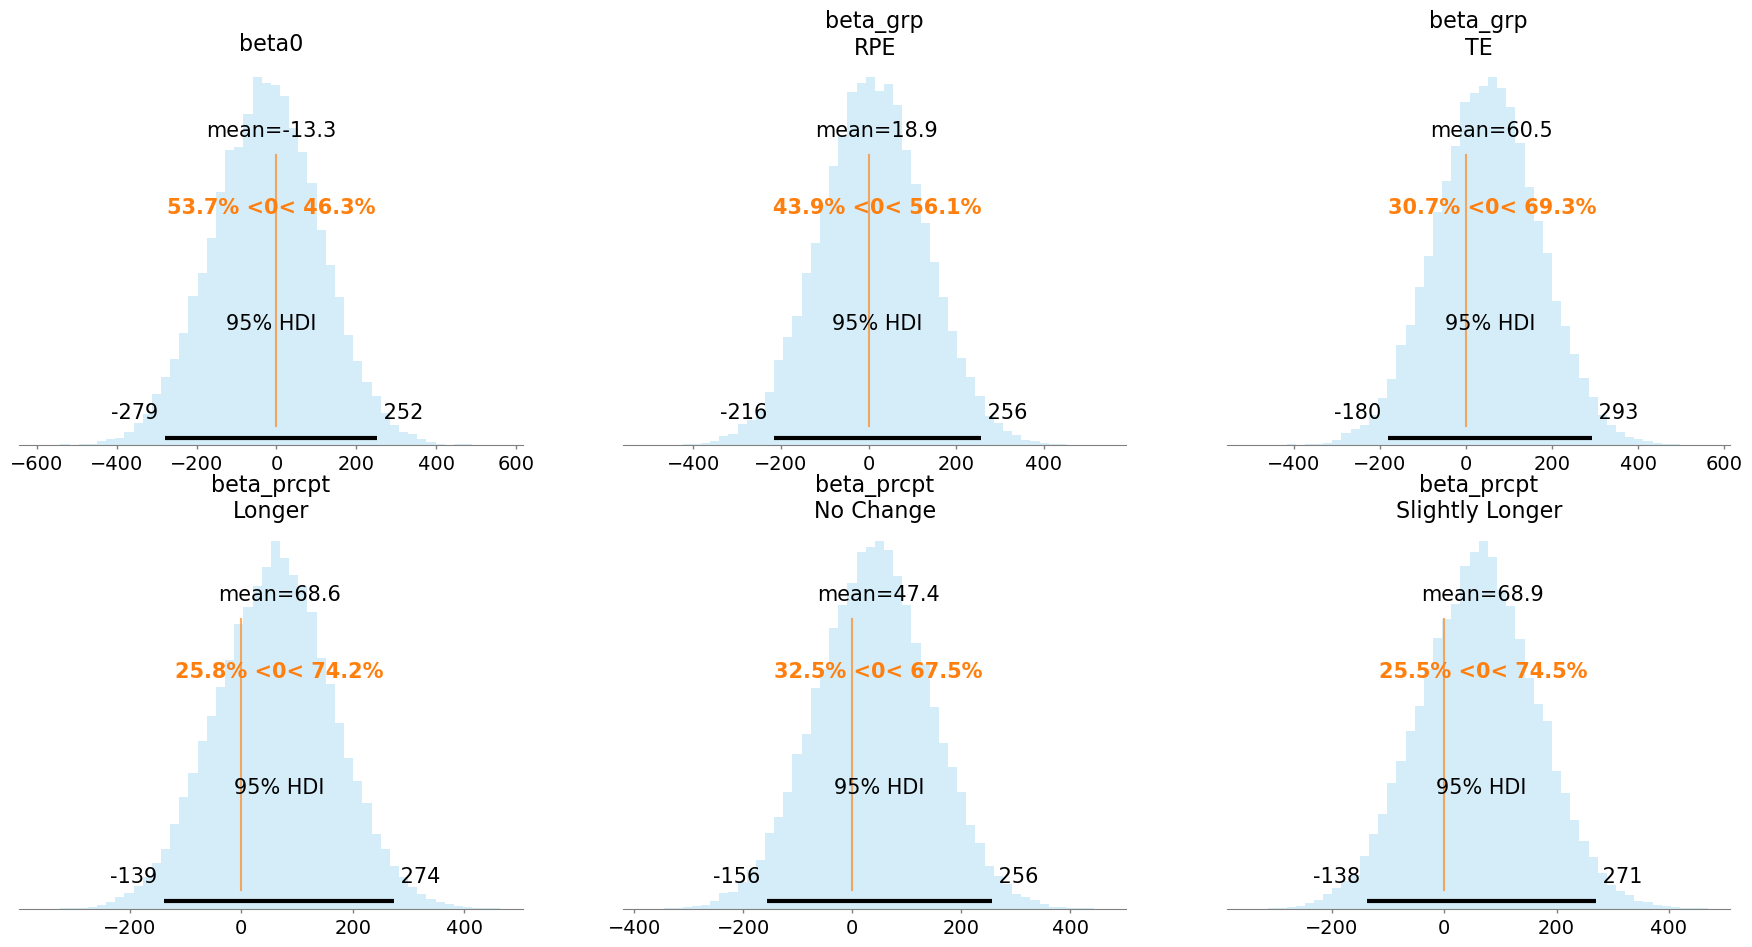

In [330]:
post_ret24_cog = az.extract(idata_ret24_cog.posterior)

az.plot_posterior(
    post_ret24_cog,
    var_names=["beta0", "beta_grp", "beta_prcpt"],
    combine_dims={"sample"}, 
    point_estimate="mean",
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
);

In [331]:
longer_hdi = az.hdi(post_ret24_cog.beta_prcpt.sel(perception='Longer').values, hdi_prob=0.95, combine_dims={"sample"})
slight_hdi = az.hdi(post_ret24_cog.beta_prcpt.sel(perception='Slightly Longer').values, hdi_prob=0.95, combine_dims={"sample"})
nc_hdi = az.hdi(post_ret24_cog.beta_prcpt.sel(perception='No Change').values, hdi_prob=0.95, combine_dims={"sample"})

print('beta longer posterior =', np.round(np.mean(post_ret24_cog.beta_prcpt.sel(perception='Longer').values),round_to), np.round(longer_hdi,round_to))
print('beta slightly longer posterior =', np.round(np.mean(post_ret24_cog.beta_prcpt.sel(perception='Slightly Longer').values),round_to), np.round(slight_hdi,round_to))
print('beta no change posterior =', np.round(np.mean(post_ret24_cog.beta_prcpt.sel(perception='No Change').values),round_to), np.round(nc_hdi,round_to))


beta longer posterior = 68.552 [-139.232  273.903]
beta slightly longer posterior = 68.923 [-137.599  270.646]
beta no change posterior = 47.355 [-156.257  255.636]


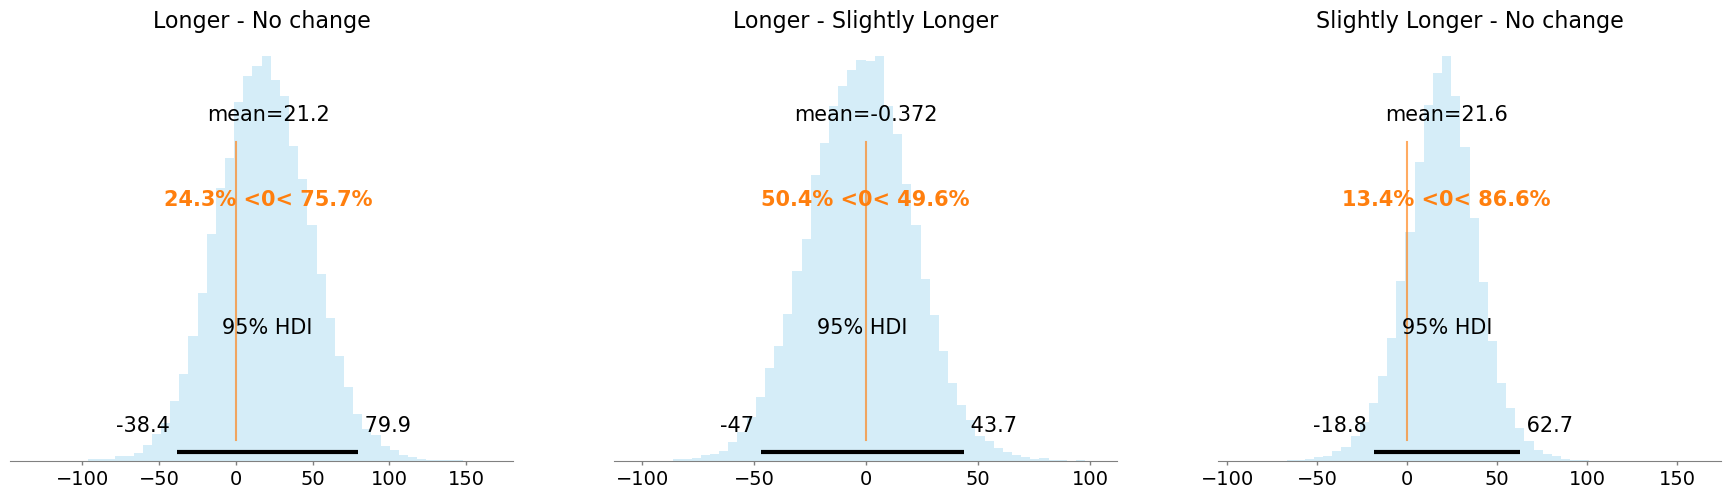

In [332]:
#Build contrasts
contrast = {"Longer - No change": post_ret24_cog.beta_prcpt.sel(perception='Longer') - post_ret24_cog.beta_prcpt.sel(perception='No Change'),
            "Longer - Slightly Longer": post_ret24_cog.beta_prcpt.sel(perception='Longer') - post_ret24_cog.beta_prcpt.sel(perception='Slightly Longer'),
            "Slightly Longer - No change": post_ret24_cog.beta_prcpt.sel(perception='Slightly Longer') - post_ret24_cog.beta_prcpt.sel(perception='No Change')
           }

az.plot_posterior(
    contrast,
    combine_dims={"sample"}, 
    point_estimate="mean",
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
);